# Prior Predictive Modeling in Bayesian AB Testing

In this notebook we generate a simulation to reproduce the results of the great blog post ["The Bet Test: Spotting Problems in Bayesian A/B Test Analysis"](https://www.geteppo.com/blog/the-bet-test-problems-in-bayesian-ab-test-analysis), where [Tyler Buffington](https://www.geteppo.com/author/tyler-buffington) discussed about some caveats of using Bayesian AB testing when not thinking about the prior predictive distribution on the key metrics of interested. If you haven't read it yet, please do it before continuing ;) 

In a nutshell, the blog post showcases the risk of using informative priors to speed-up A/B tests in a naive way. To be fair, it is easy to fall into this trap (I have been there 🙈), so I think it is great to have these discussions to make us think twice about what we are doing.

## Business Context

The setting is "simple" we want to set up a Bayesian model on conversion rates using informative priors about what we know about the context. How hard can it be? 🤭 As good Bayesians, we want to set up meaningful priors to bound the range of the estimates. From the blog post:

> *Renowned Bayesian statistician Andrew Gelman has also [warned against the dangers of noninformative priors](https://statmodeling.stat.columbia.edu/2013/11/21/hidden-dangers-noninformative-priors/) in “any setting where the prior information really is strong, so that if you assume a flat prior, you can get silly estimates simply from noise variation.” This is the exact setting of A/B testing. The range of true lifts is well known, but business metrics are noisy, which leads to silly estimates that make the [Twyman's law scenario](https://en.wikipedia.org/wiki/Twyman%27s_law) so common.*

[**Twyman's law**](https://en.wikipedia.org/wiki/Twyman%27s_law) states that "Any figure that looks interesting or different is usually wrong" 🙃

Hence, we want a model that bounds realistic set of experiment outcomes **before seeing the data**, i.e. on prior predictive modeling (which we should always do!).

For example, if our typical conversion rates are around $2\%$, we would need a lot (really a lot!) of evidence to convince us that the treatment variant conversion rate can boost up to $20\%$ (a 10x lift).

What is the solution? Well, simply set informative in the conversion rates...right? right? Well, as we will see, it is not that simple (but also not that hard!, it just requires us to think a little bit more about the fact we are modeling a joint posterior and not just the marginals).

## Prepare Notebook

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import preliz as pz
import pymc as pm

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
seed: int = sum(map(ord, "bayesian_ab_testing"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

## Non-Informative Model

To run the prior predictive modeling we do not need data 😎, we just need to think about the business problem. To start with a baseline, let's consider the non-informative model where we set flat priors on the conversion rates (please do not do this in practice 🙏).
We also save in the trace object the **relative lift** defined as 

$$
\text{relative lift} = \frac{\text{treatment conversion rate}}{\text{control conversion rate}} - 1
$$

This is the quantity we are interested in.

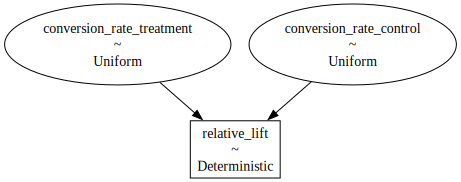

In [3]:
with pm.Model() as non_informative_model:
    conversion_rate_control = pm.Uniform("conversion_rate_control", lower=0, upper=1)
    conversion_rate_treatment = pm.Uniform(
        "conversion_rate_treatment", lower=0, upper=1
    )
    relative_lift = pm.Deterministic(
        "relative_lift",
        conversion_rate_treatment / conversion_rate_control - 1,
    )

pm.model_to_graphviz(non_informative_model)

Next we sample from the prior predictive distribution.


In [4]:
with non_informative_model:
    non_informative_prior_samples = pm.sample_prior_predictive(
        samples=1_000, random_seed=rng
    )

Sampling: [conversion_rate_control, conversion_rate_treatment]


Let's visualize the prior predictive distribution of the conversion rates.

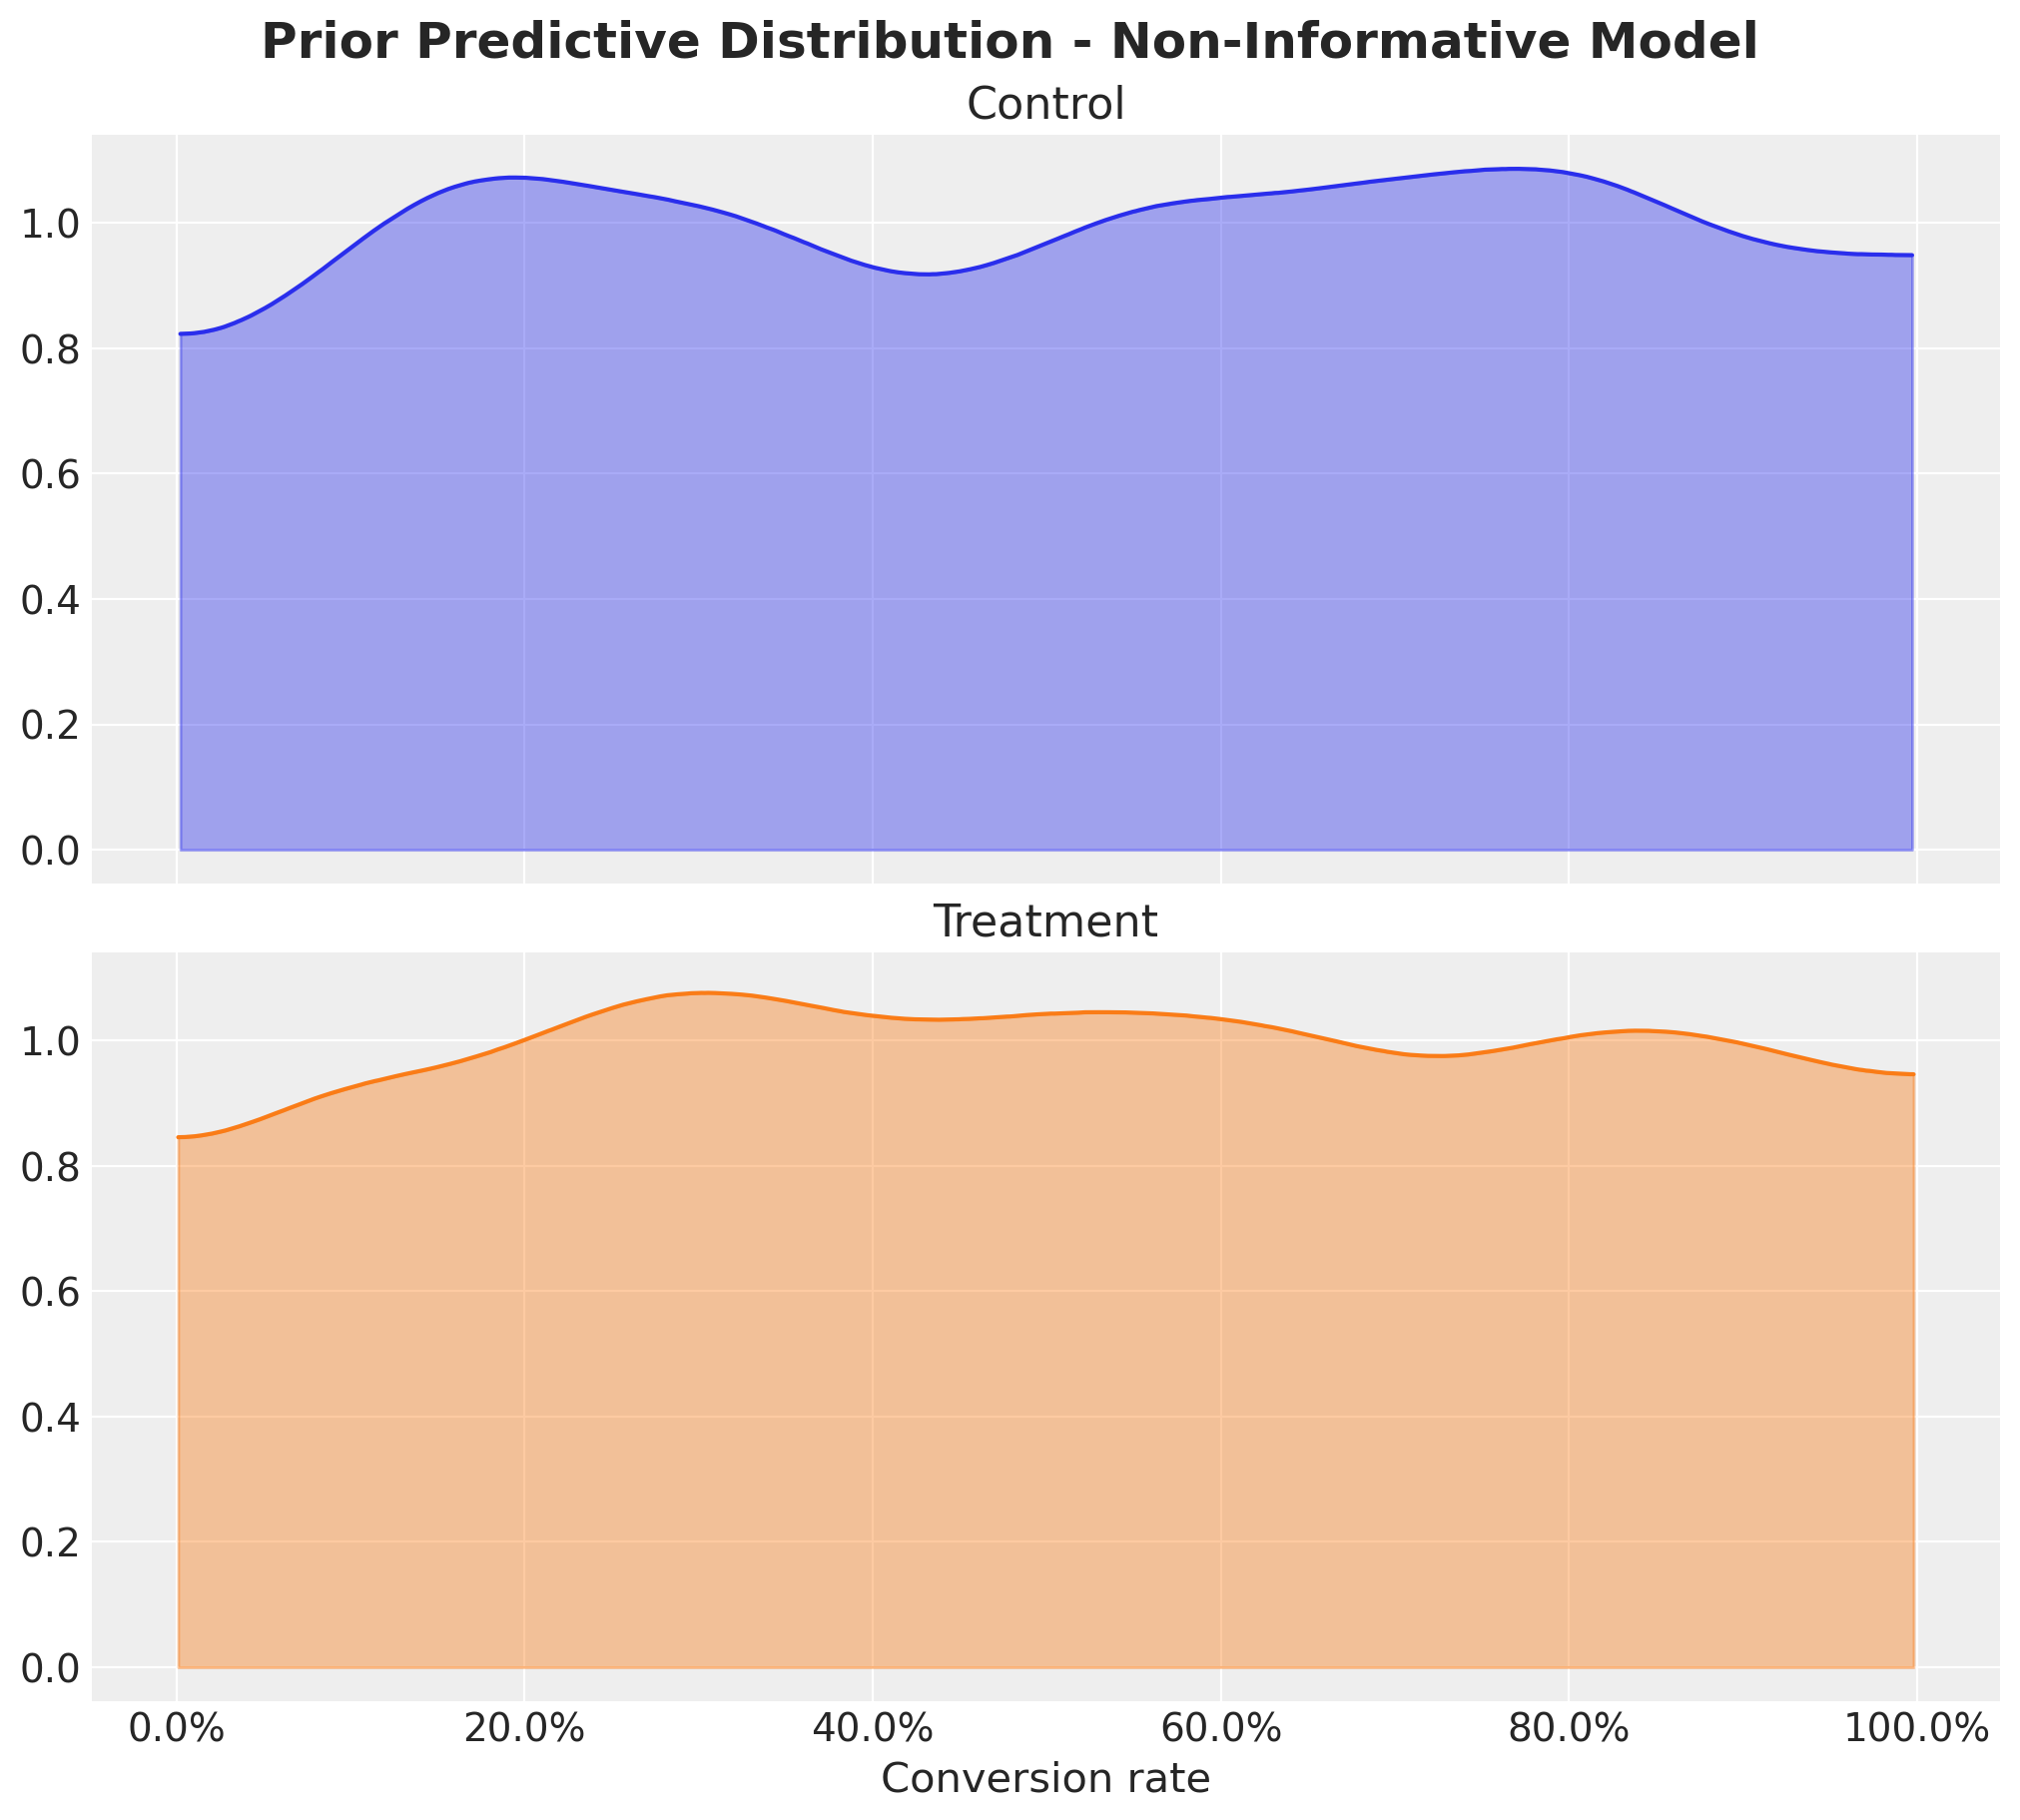

In [5]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(10, 9), sharex=True, sharey=True, layout="constrained"
)

az.plot_dist(
    non_informative_prior_samples["prior"]["conversion_rate_control"],
    color="C0",
    fill_kwargs={"alpha": 0.4},
    ax=ax[0],
)
ax[0].set_title("Control")

az.plot_dist(
    non_informative_prior_samples["prior"]["conversion_rate_treatment"],
    color="C1",
    fill_kwargs={"alpha": 0.4},
    ax=ax[1],
)
ax[1].set(title="Treatment", xlabel="Conversion rate")
ax[1].xaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=1))
fig.suptitle(
    "Prior Predictive Distribution - Non-Informative Model",
    fontsize=18,
    fontweight="bold",
);

As expected, they are flat. We can further look into the joint distribution of the conversion rates.

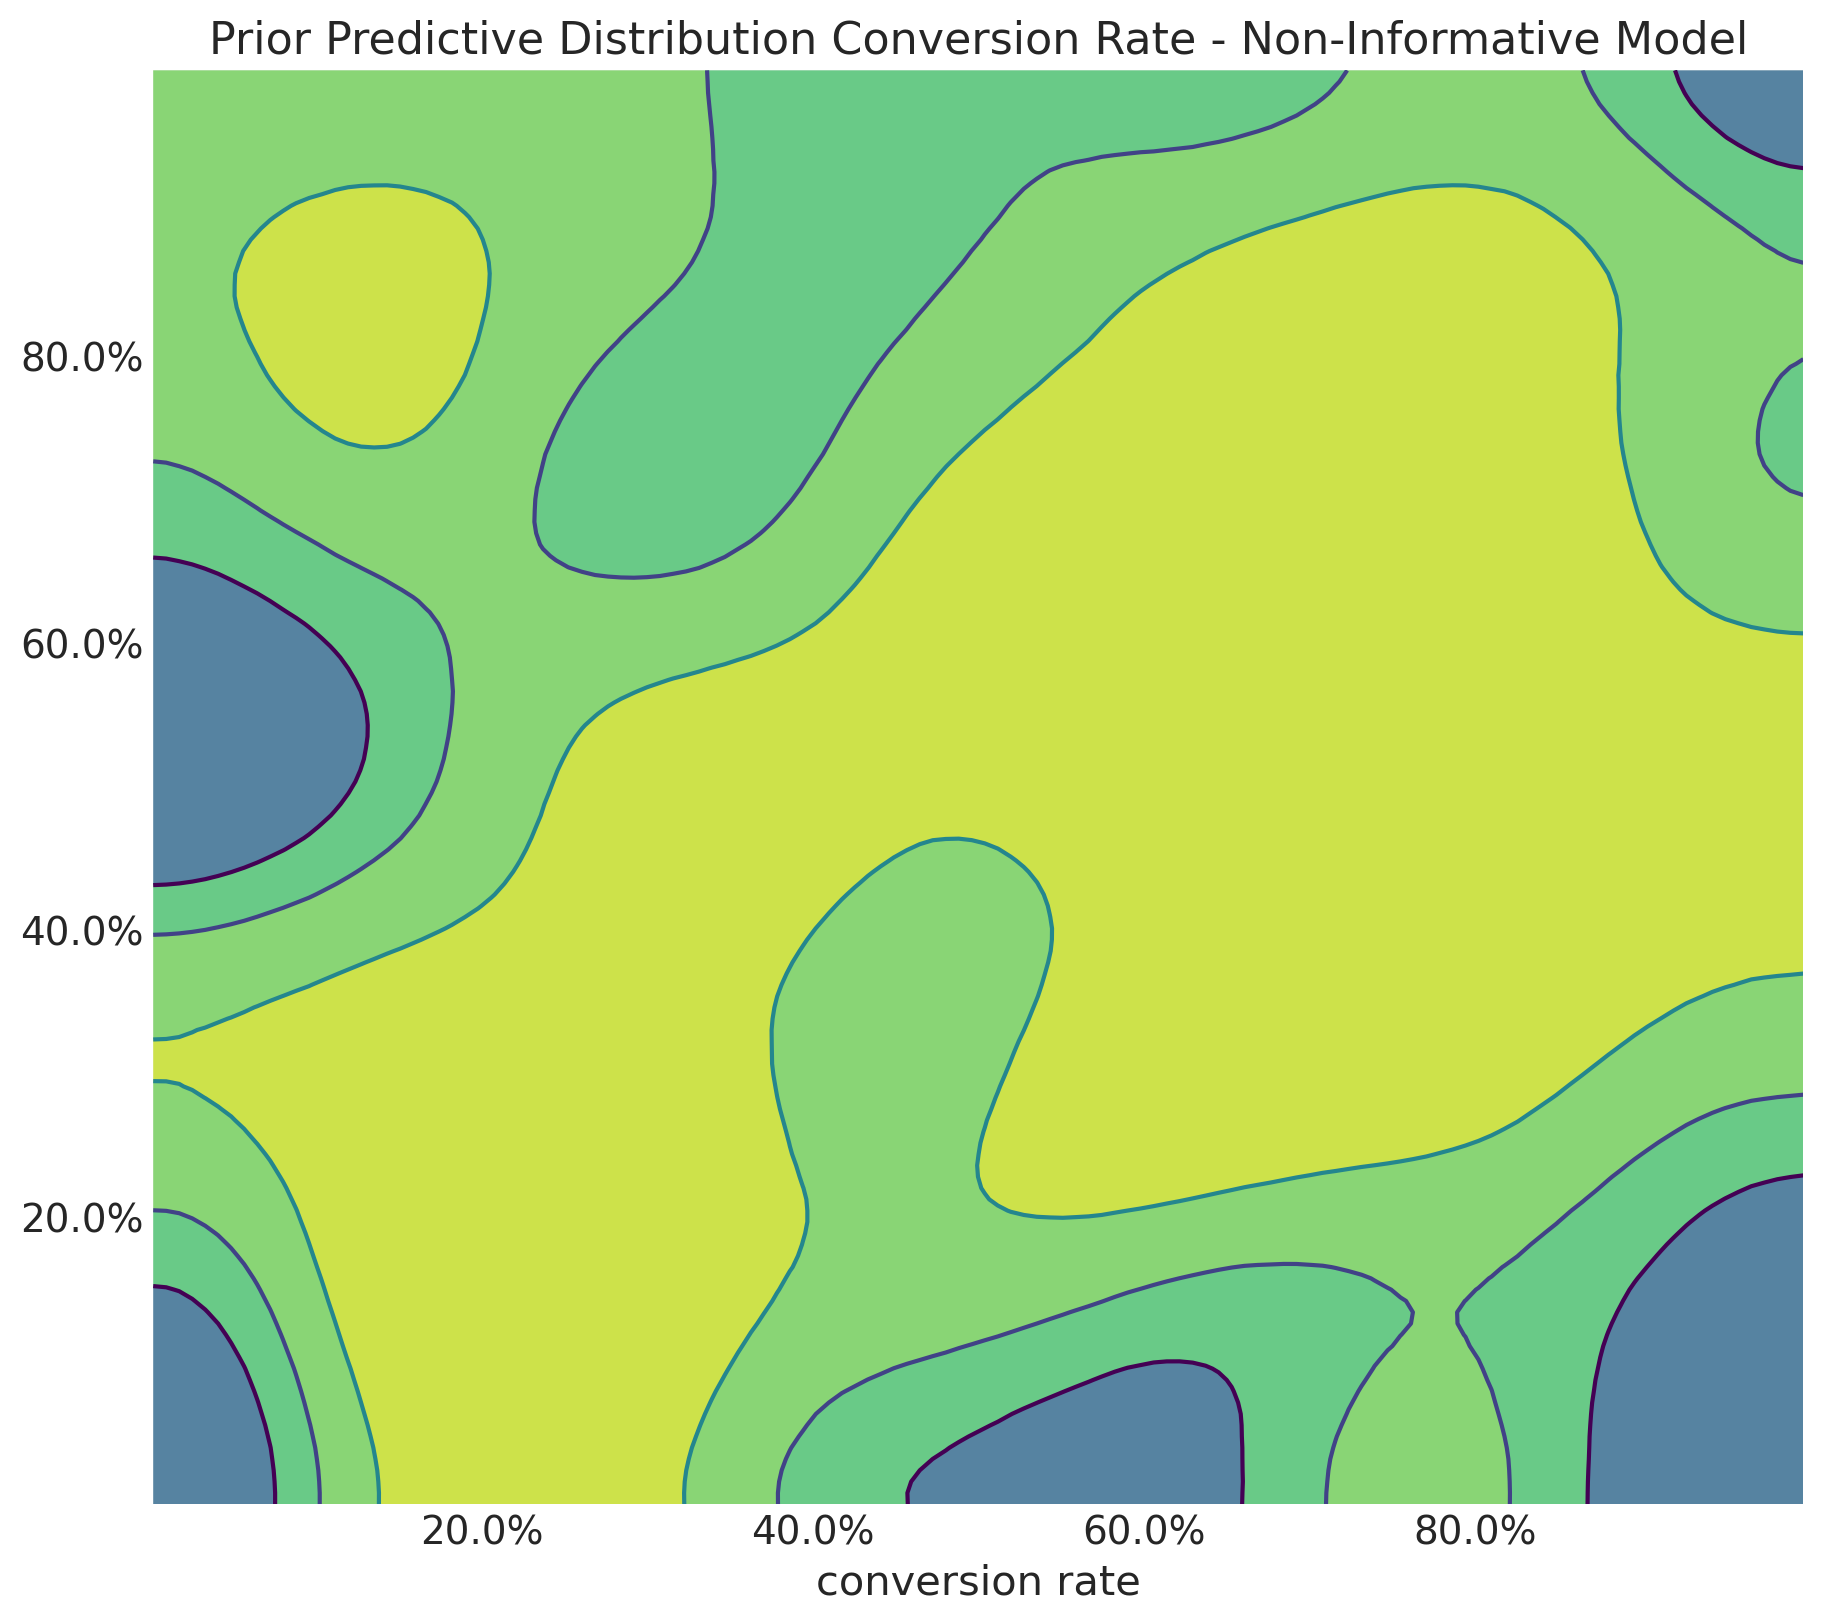

In [6]:
fig, ax = plt.subplots(figsize=(9, 8))
az.plot_dist(
    values=non_informative_prior_samples["prior"]["conversion_rate_control"],
    values2=non_informative_prior_samples["prior"]["conversion_rate_treatment"],
    contour_kwargs={"colors": None, "cmap": plt.cm.viridis},
    contourf_kwargs={"alpha": 0.8},
    ax=ax,
)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=1))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=1))
ax.set(
    title="Prior Predictive Distribution Conversion Rate - Non-Informative Model",
    xlabel="conversion rate",
);

Unsurprisingly, the joint distribution is also flat.

Finally, let's consider the prior predictive distribution of the relative lift: 

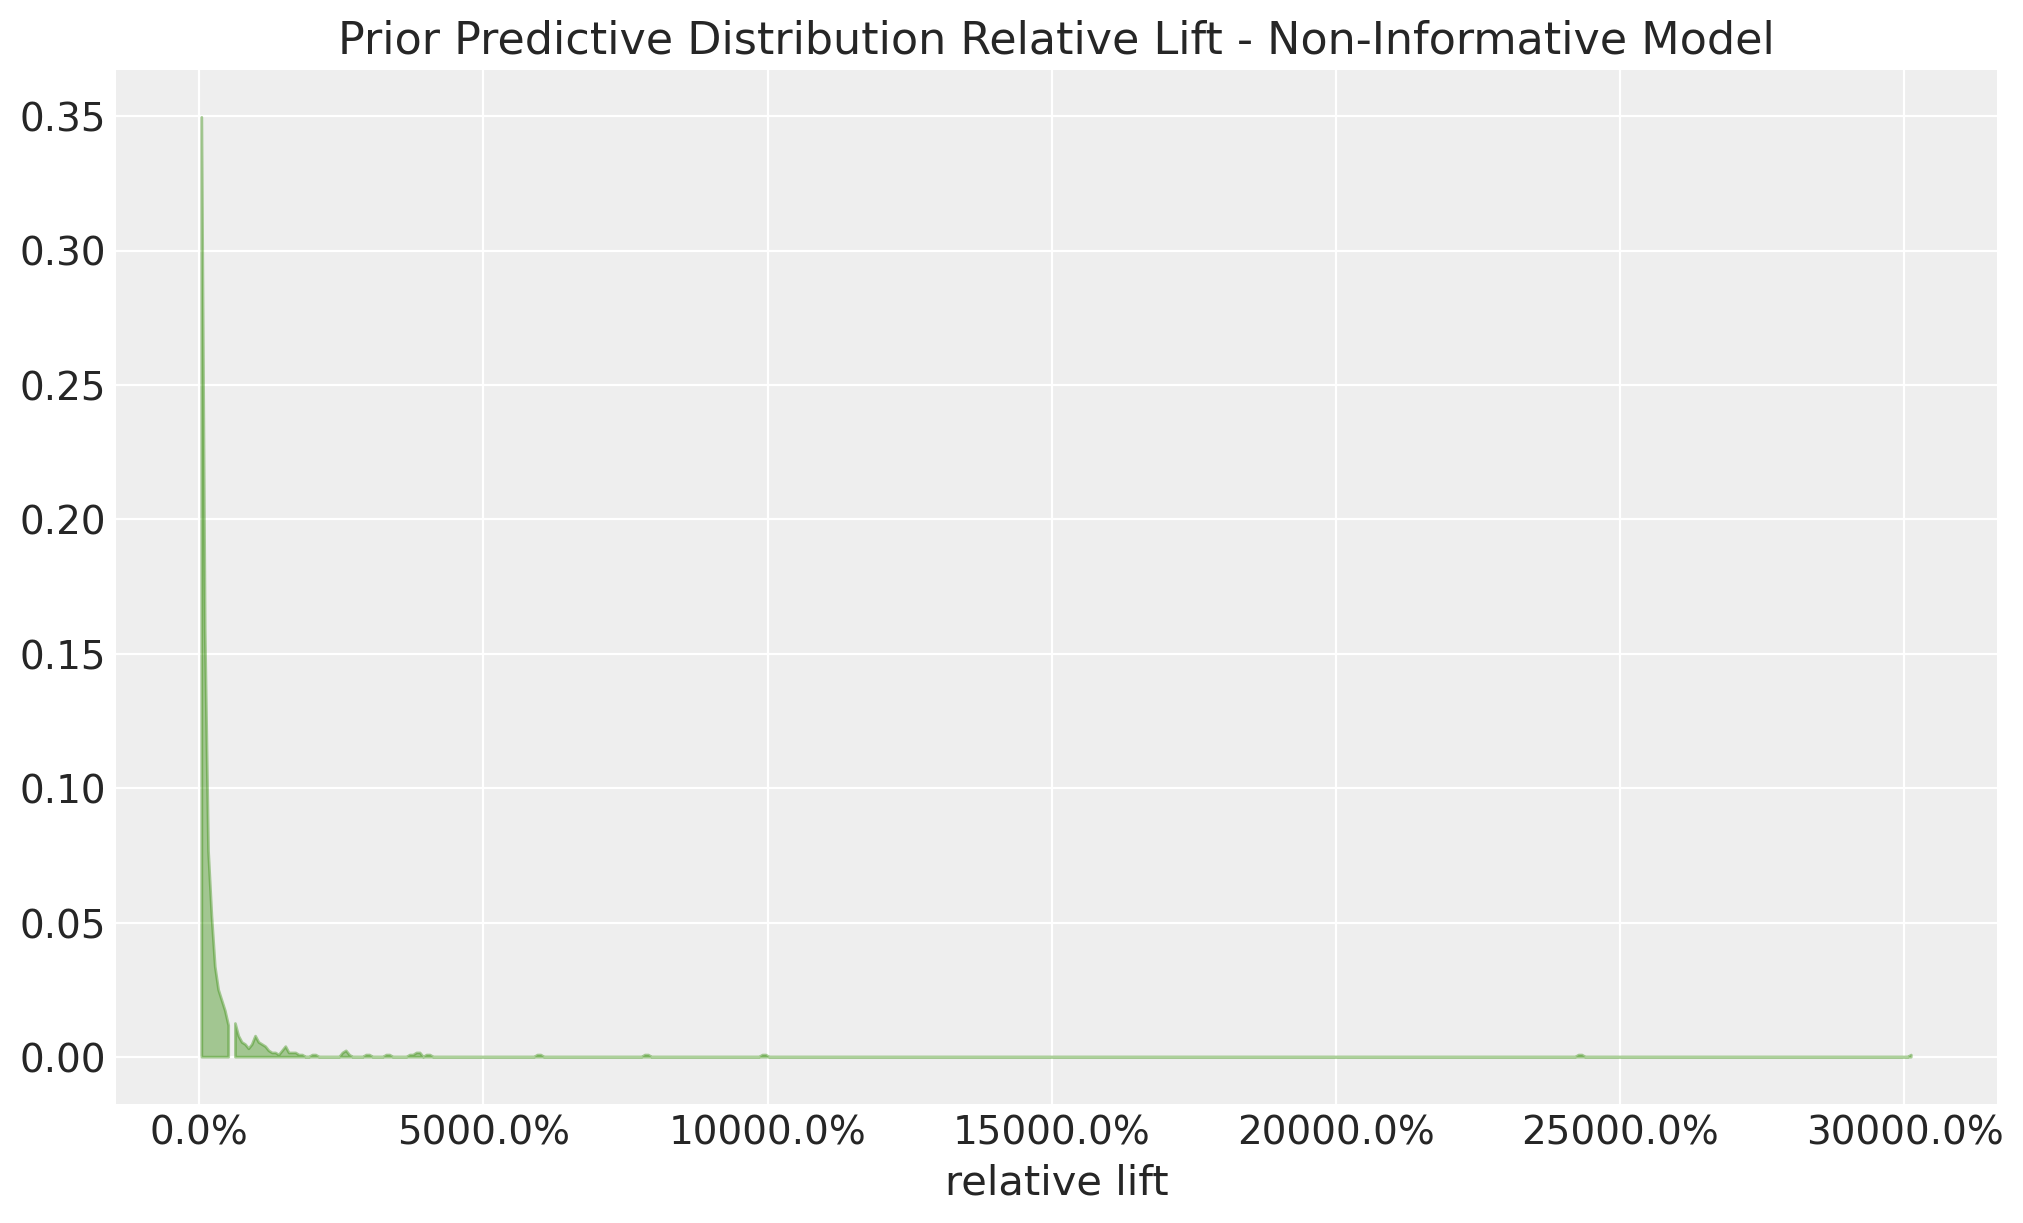

In [7]:
fig, ax = plt.subplots()
az.plot_dist(
    non_informative_prior_samples["prior"]["relative_lift"],
    color="C2",
    quantiles=[0.06, 0.5, 0.94],
    fill_kwargs={"alpha": 0.4},
    ax=ax,
)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=1))
ax.set(
    title="Prior Predictive Distribution Relative Lift - Non-Informative Model",
    xlabel="relative lift",
);

Well, this is all over the place, in essence, we are saying that the treatment variant can be 100x better than the control variant (actually, even more!). This is very unrealistic in practice, so we need to do better.

How bad can this be? I have found useful to compute the share of samples outside of a given range in absolute value:

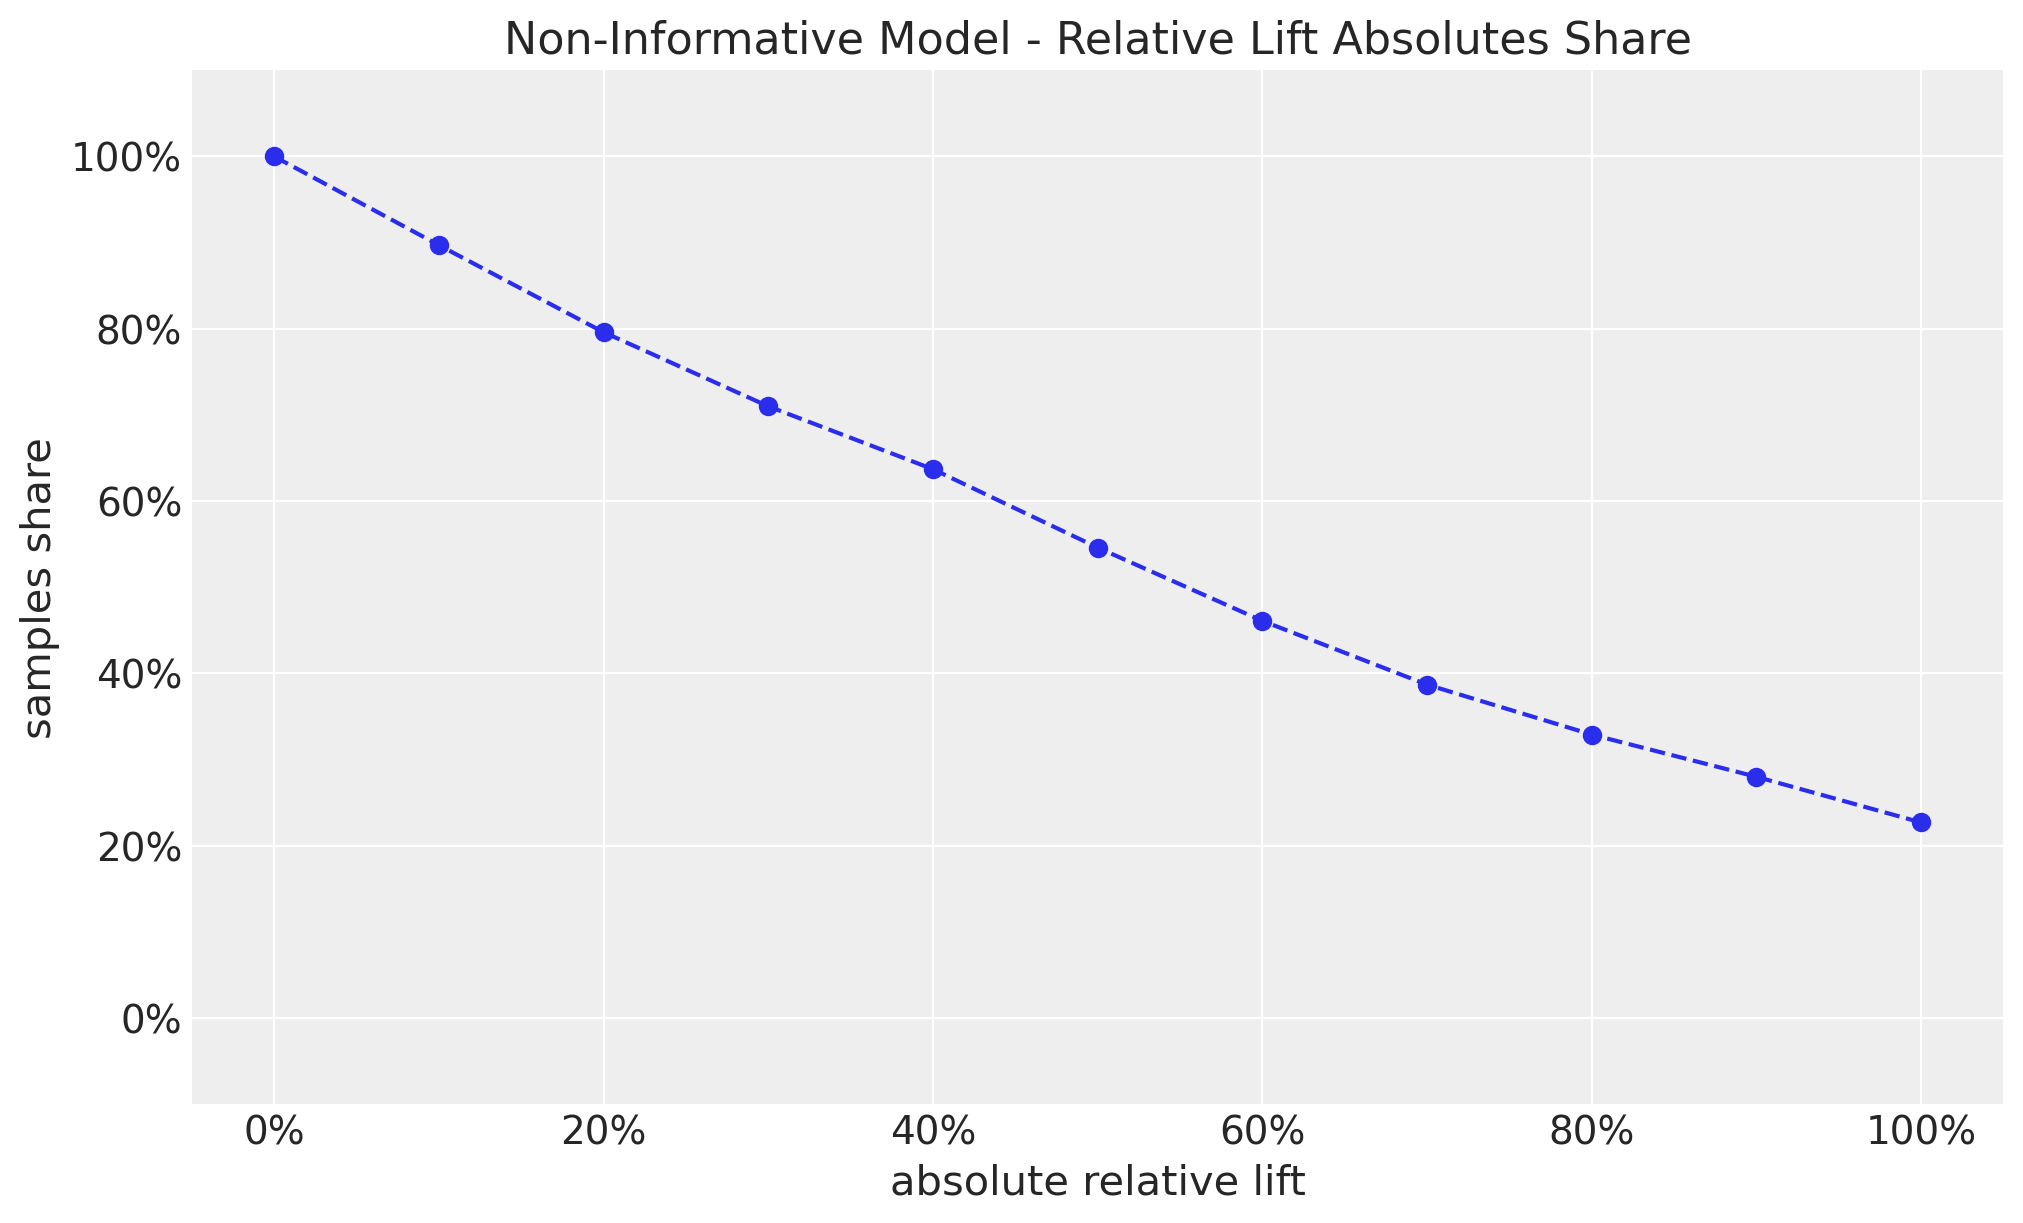

In [8]:
thresholds = np.linspace(start=0, stop=1, num=11)

shares = [
    (
        np.abs(non_informative_prior_samples["prior"]["relative_lift"]) >= threshold
    ).mean()
    for threshold in thresholds
]

fig, ax = plt.subplots()
ax.plot(thresholds, shares, marker="o", linestyle="--", color="C0")
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))
ax.set(
    title="Non-Informative Model - Relative Lift Absolutes Share",
    xlabel="absolute relative lift",
    ylabel="samples share",
    ylim=(-0.1, 1.1),
);

This shows that we have approximately a $50\%$ chance of having a relative lift of more than $60\%$ (in absolute value). This sounds too good to be true (Think again about Twyman's law 🤔).

## Informative Model

Now let's add some informative priors on the conversion rates. We will use a Beta distribution with parameters $\alpha = 15$ and $\beta = 600$ (as suggested in the blog post). Below, we will see the reasoning behind this choice (if you can wait, the mean of a $\text{Beta}(\alpha, \beta)$ is $\alpha / (\alpha + \beta)$, which in this case is $0.15 / (0.15 + 600) = 0.024$, so around $2.4\%$ conversion rate).

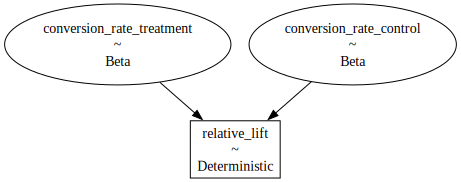

In [9]:
with pm.Model() as informative_model:
    conversion_rate_control = pm.Beta("conversion_rate_control", alpha=15, beta=600)
    conversion_rate_treatment = pm.Beta("conversion_rate_treatment", alpha=15, beta=600)
    relative_lift = pm.Deterministic(
        "relative_lift",
        conversion_rate_treatment / conversion_rate_control - 1,
    )

pm.model_to_graphviz(informative_model)

As before, we sample from the prior predictive distribution.

In [10]:
with informative_model:
    informative_prior_samples = pm.sample_prior_predictive(
        samples=1_000, random_seed=rng
    )

Sampling: [conversion_rate_control, conversion_rate_treatment]


Let's visualize the prior predictive distribution of the conversion rates:

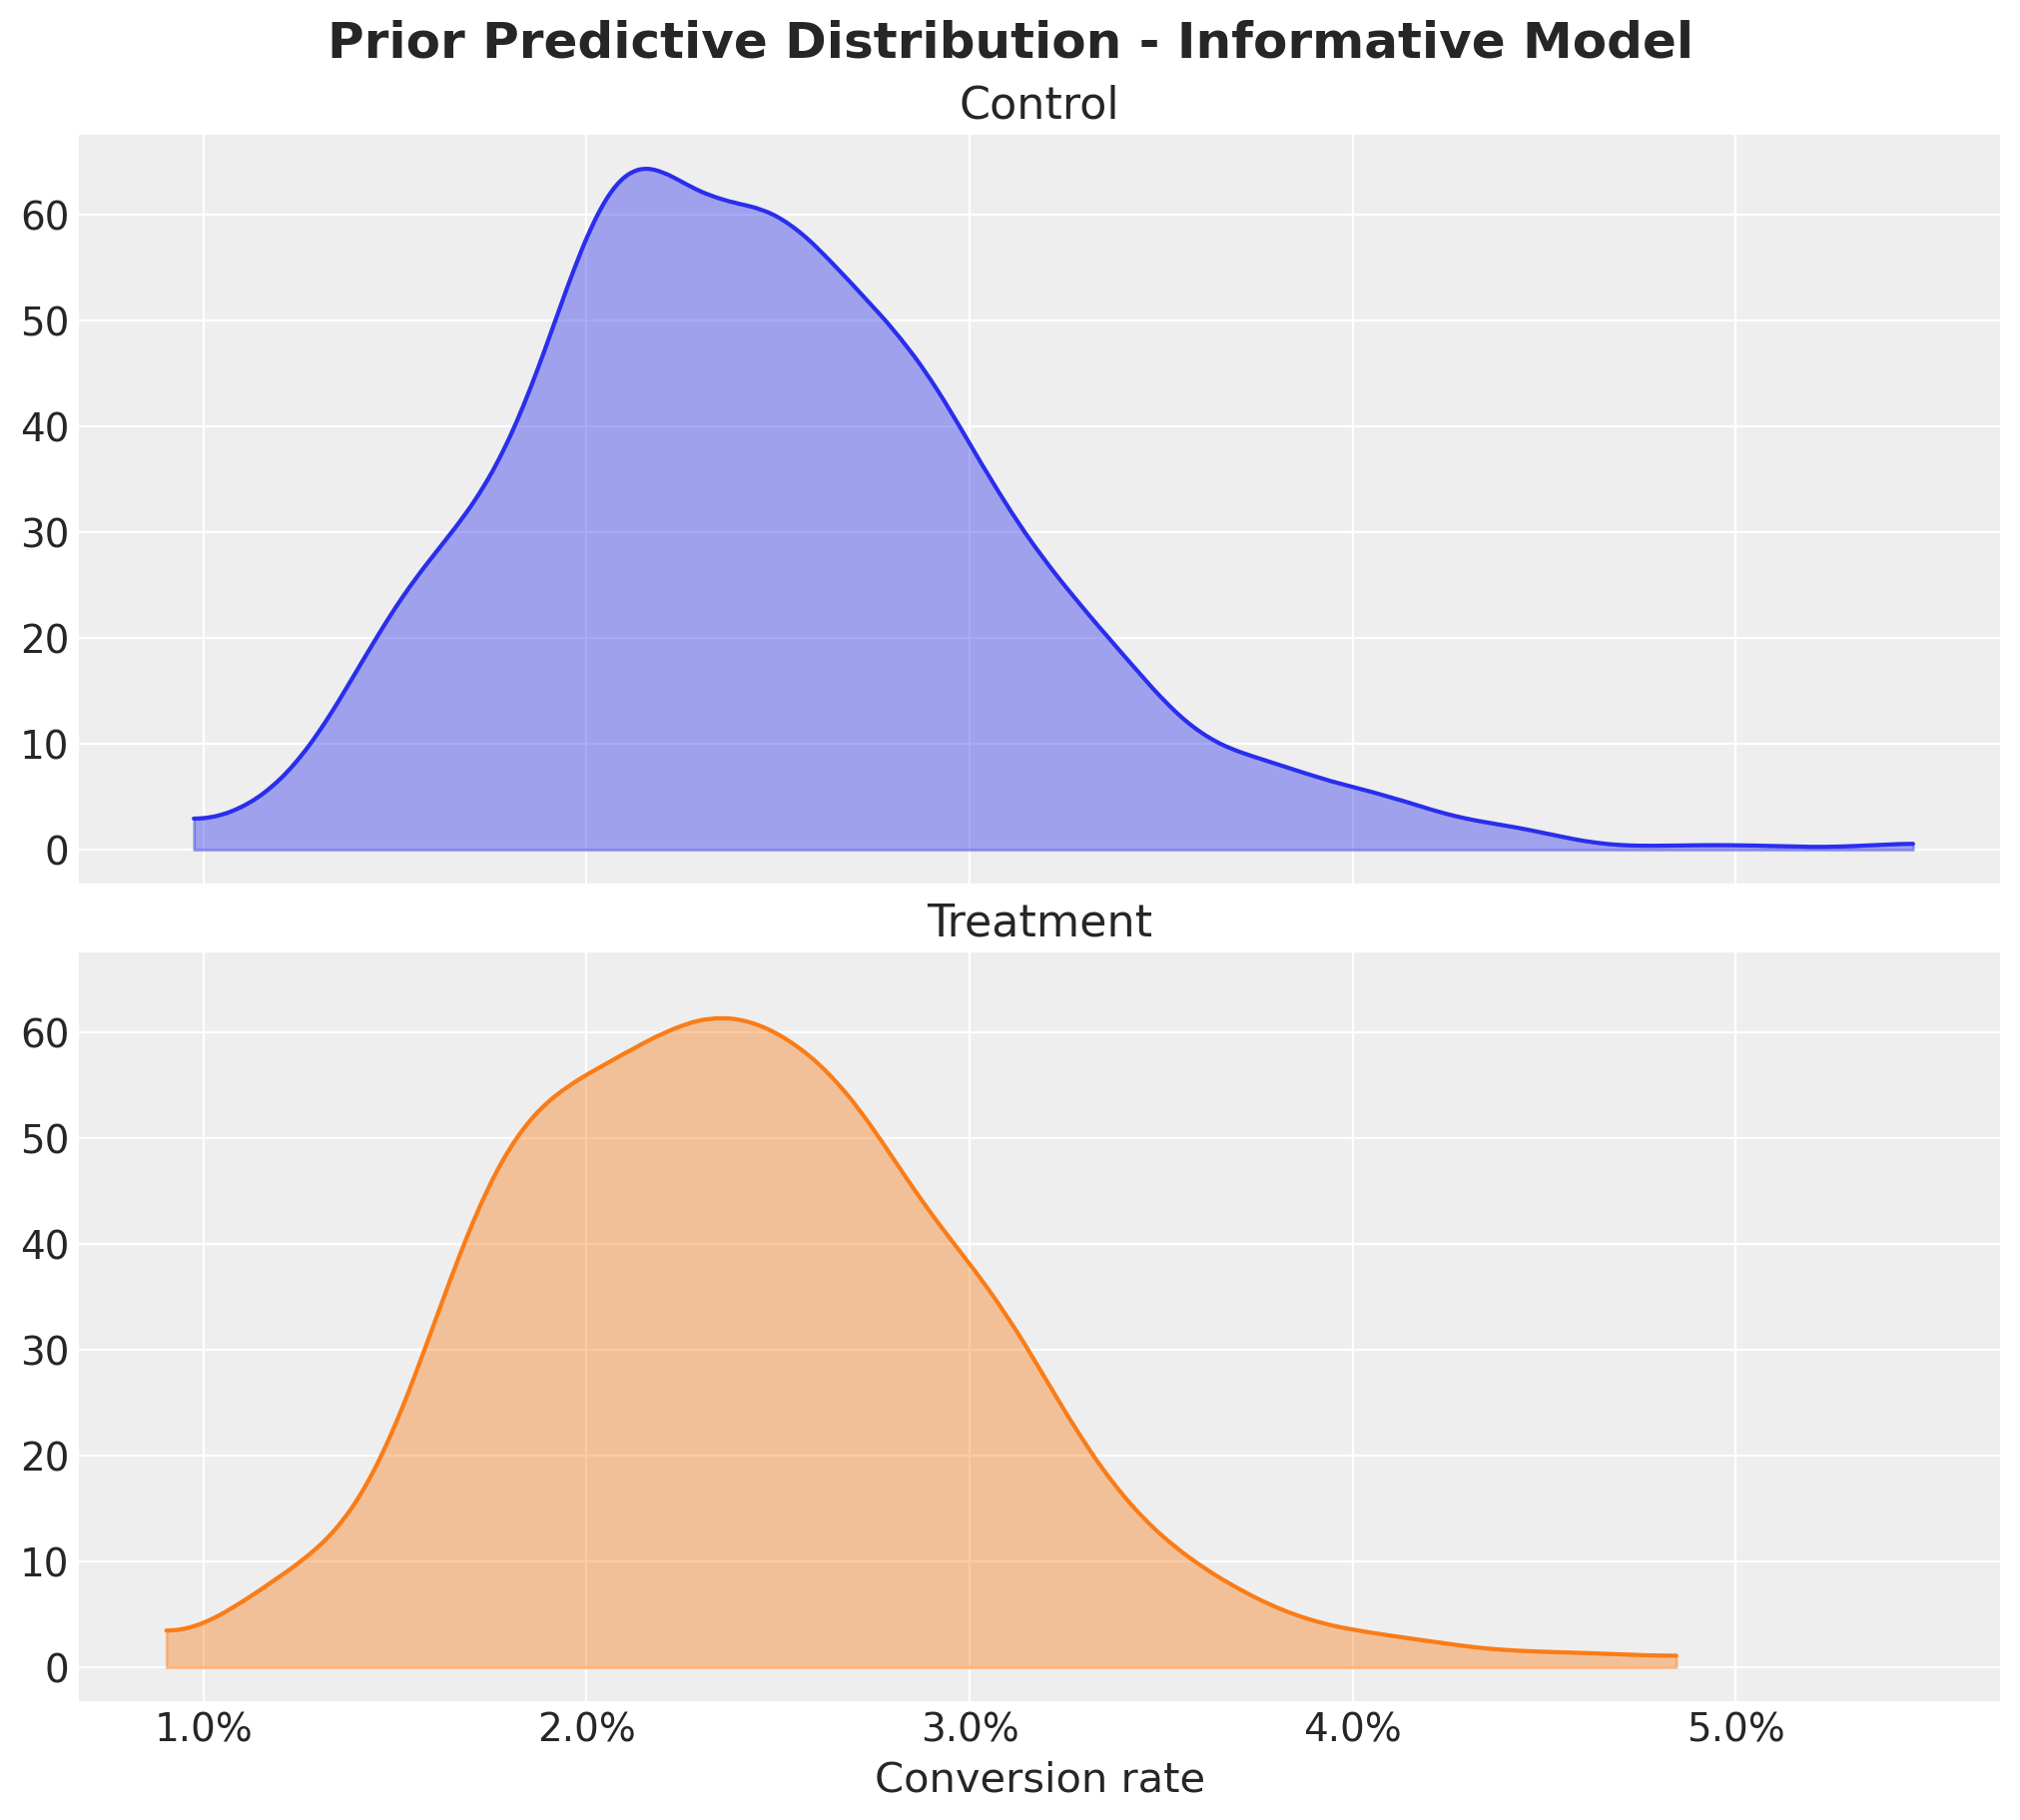

In [11]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(10, 9), sharex=True, sharey=True, layout="constrained"
)

az.plot_dist(
    informative_prior_samples["prior"]["conversion_rate_control"],
    color="C0",
    fill_kwargs={"alpha": 0.4},
    ax=ax[0],
)
ax[0].set_title("Control")

az.plot_dist(
    informative_prior_samples["prior"]["conversion_rate_treatment"],
    color="C1",
    fill_kwargs={"alpha": 0.4},
    ax=ax[1],
)
ax[1].set(title="Treatment", xlabel="Conversion rate")
ax[1].xaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=1))
fig.suptitle(
    "Prior Predictive Distribution - Informative Model", fontsize=18, fontweight="bold"
);

This looks much better! For both variants, the conversion rates are concentrated around $2.4\%$ with a few samples with conversion rates close to $0\%$ and $5\%$.

**Remark:** Finding the "appropriate values" of $\alpha$ and $\beta$ is not always straightforward. There is a better way than simply "guessing". We can use [Preliz](https://preliz.readthedocs.io/en/latest/index.html) to find this through an optimization step based on our requirements regarding the support of the distribution. For instance, we can ask for the $\alpha$ and $\beta$ values that cover $94\%$ of the mass of the distribution and are between $1\%$ and $4\%$.



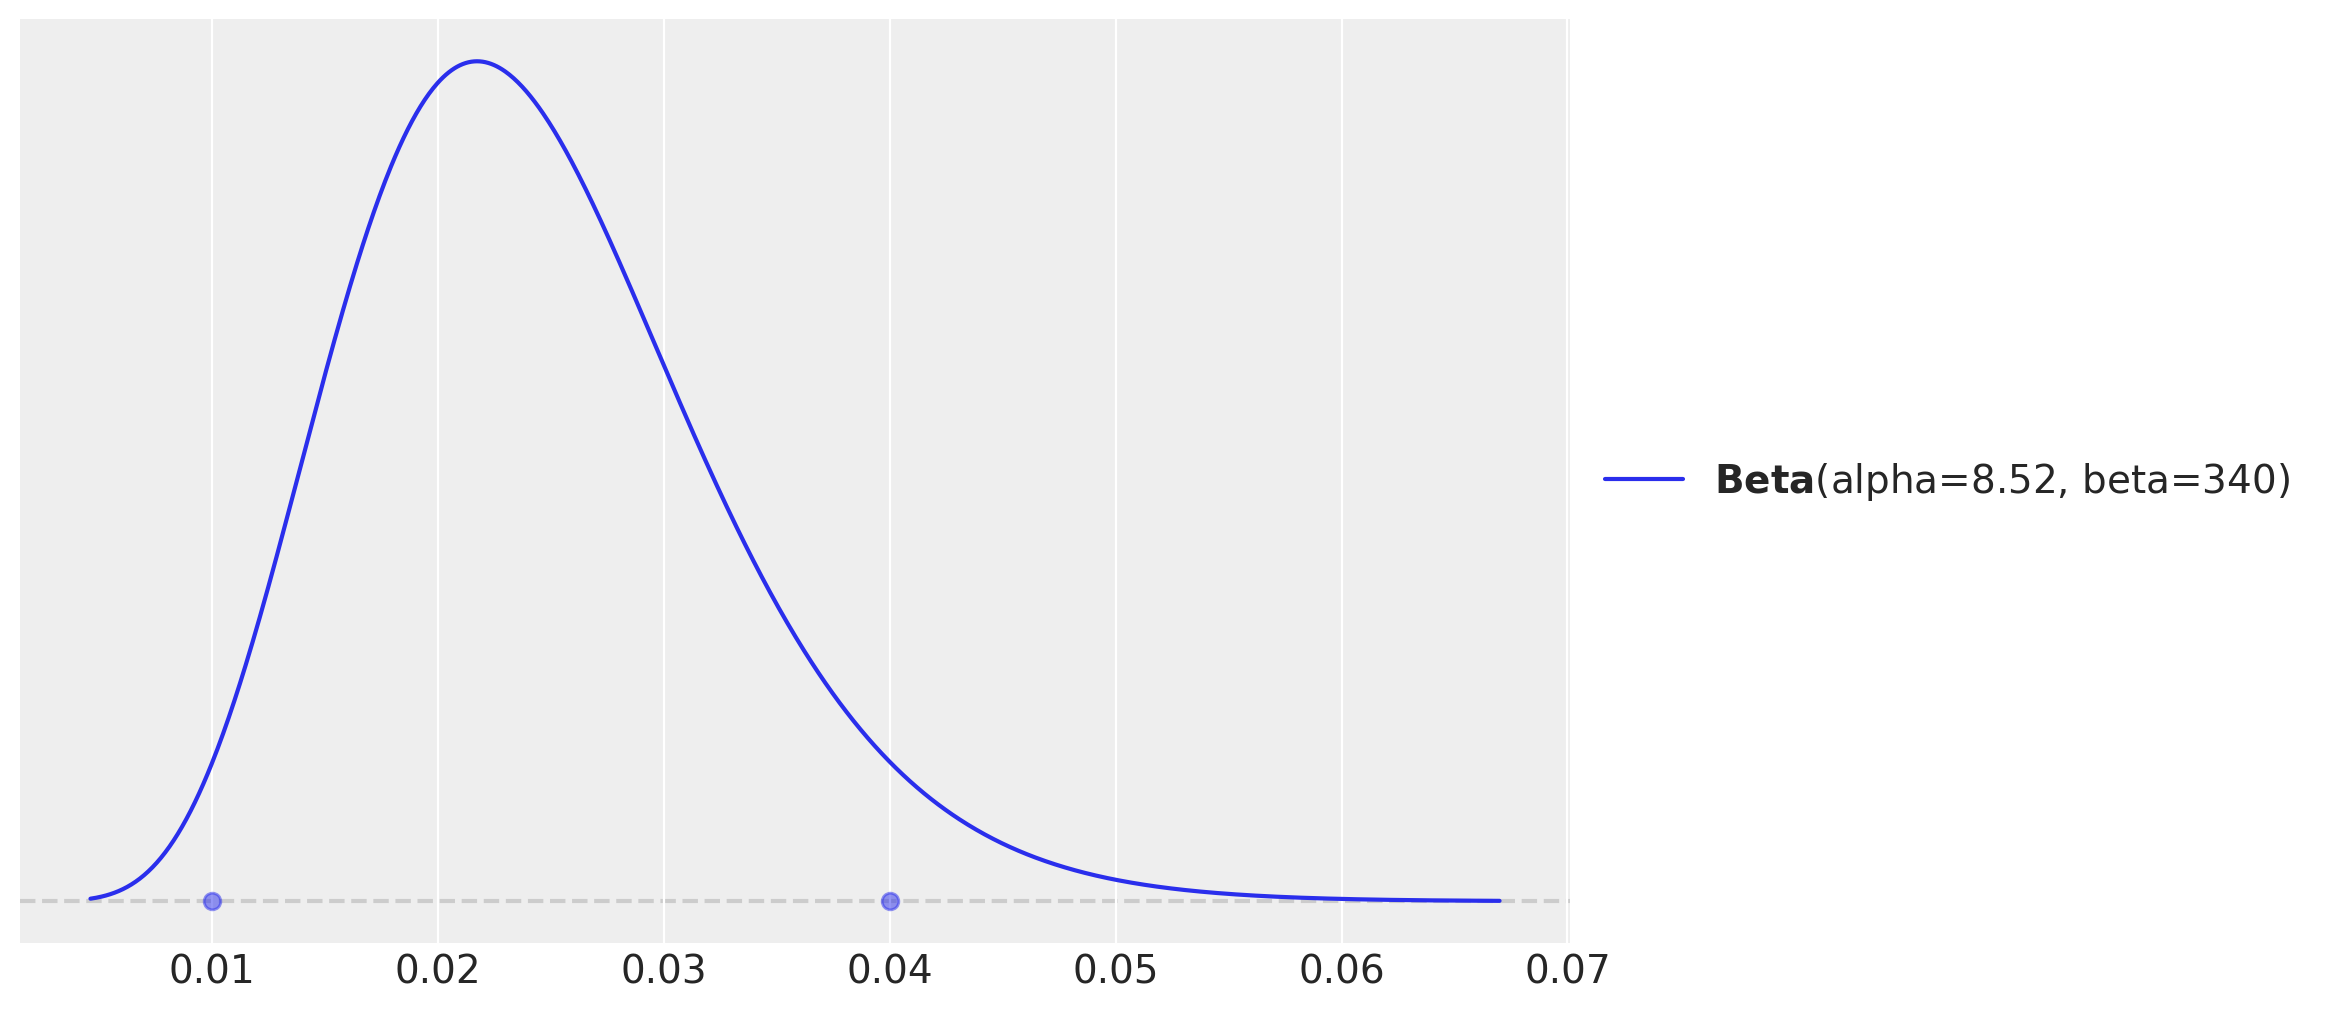

In [12]:
fig, ax = plt.subplots()
pz.maxent(pz.Beta(), lower=0.01, upper=0.04, mass=0.94, ax=ax);

These values are, up to a constant factor of $2$, the same as the ones we used in the informative model. The prior distributions are actually very similar.

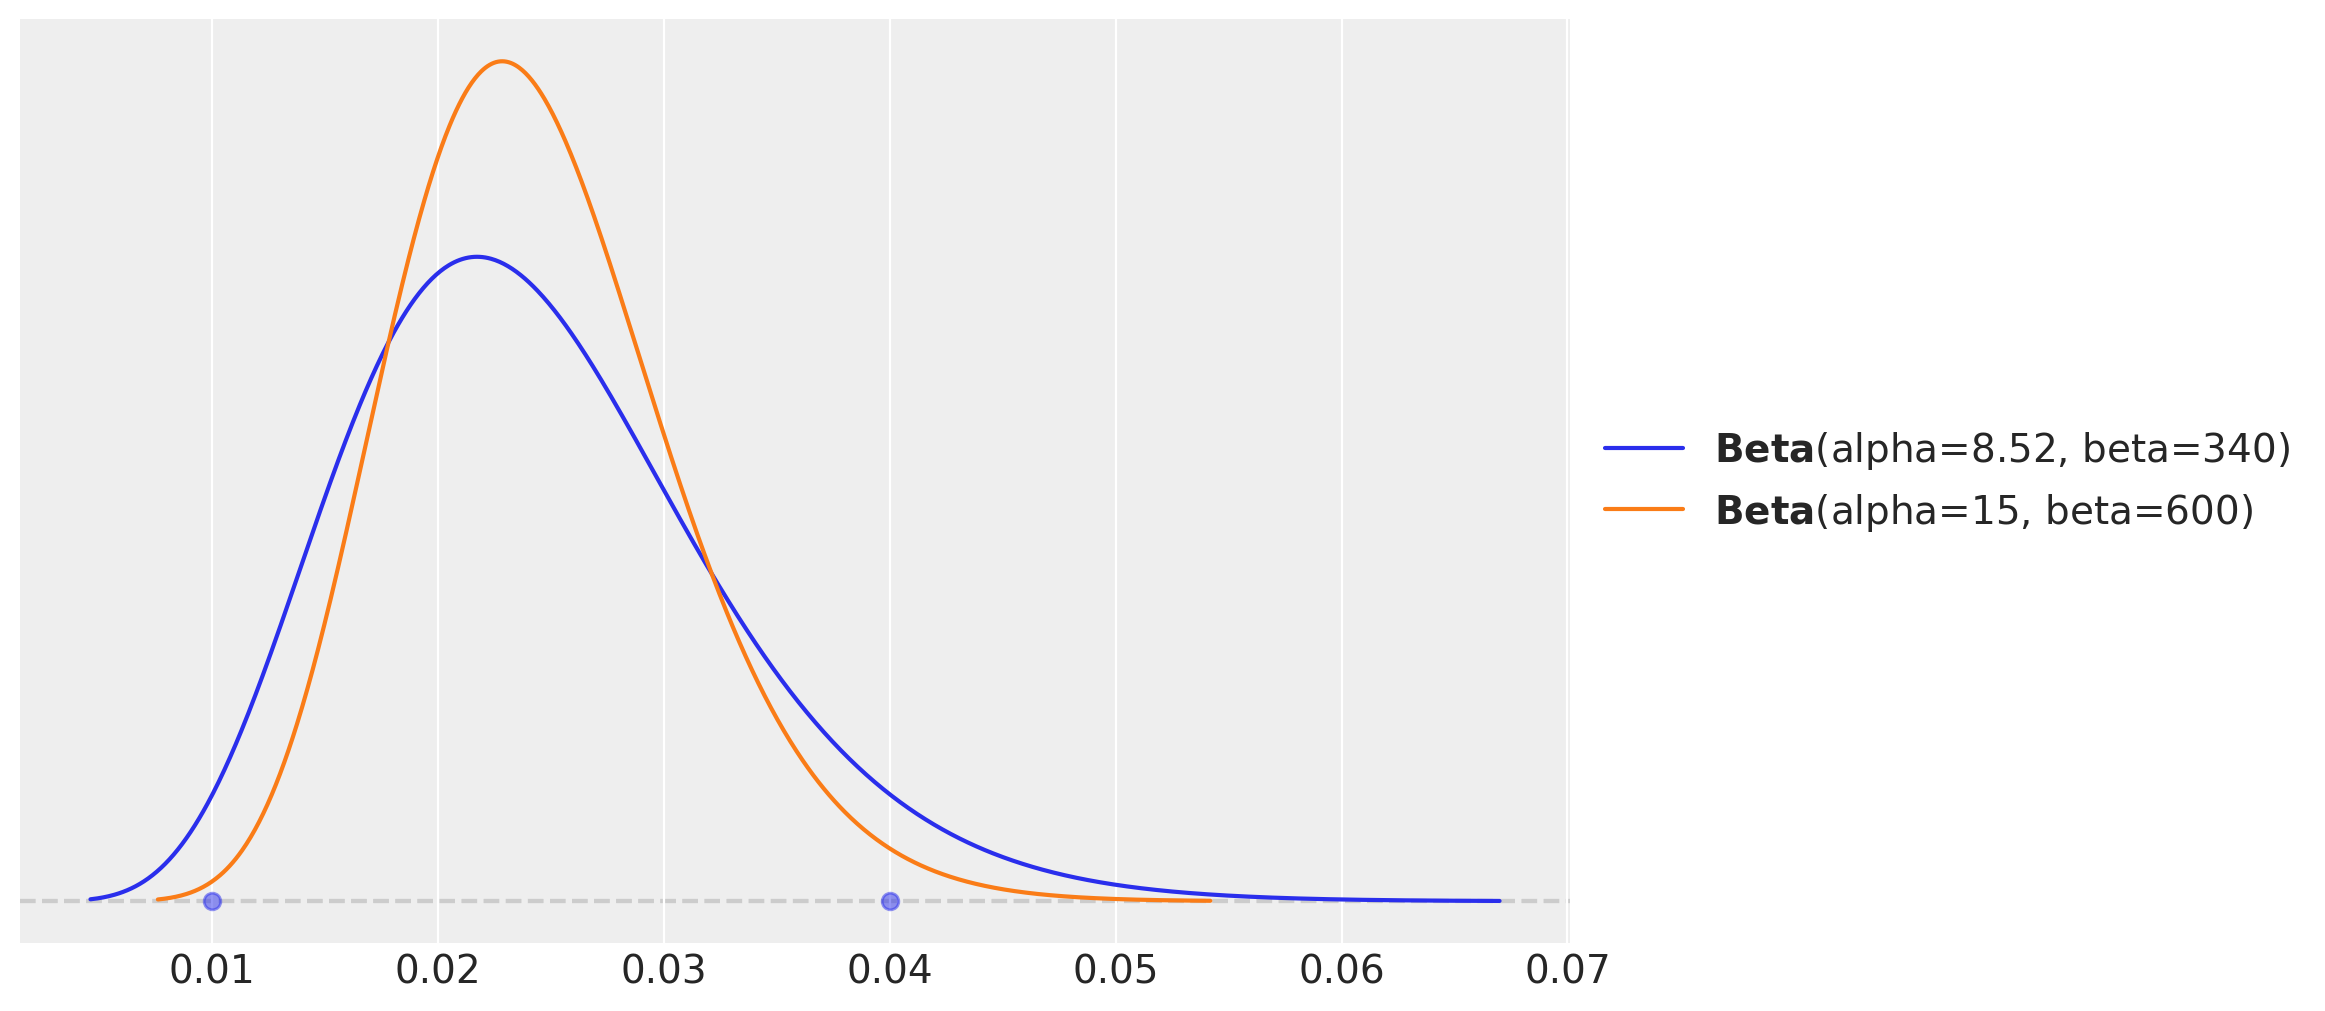

In [13]:
fig, ax = plt.subplots()
pz.maxent(pz.Beta(), lower=0.01, upper=0.04, mass=0.94, ax=ax)
pz.Beta(alpha=15, beta=600).plot_pdf(ax=ax);

So far so good! What about the joint distribution?

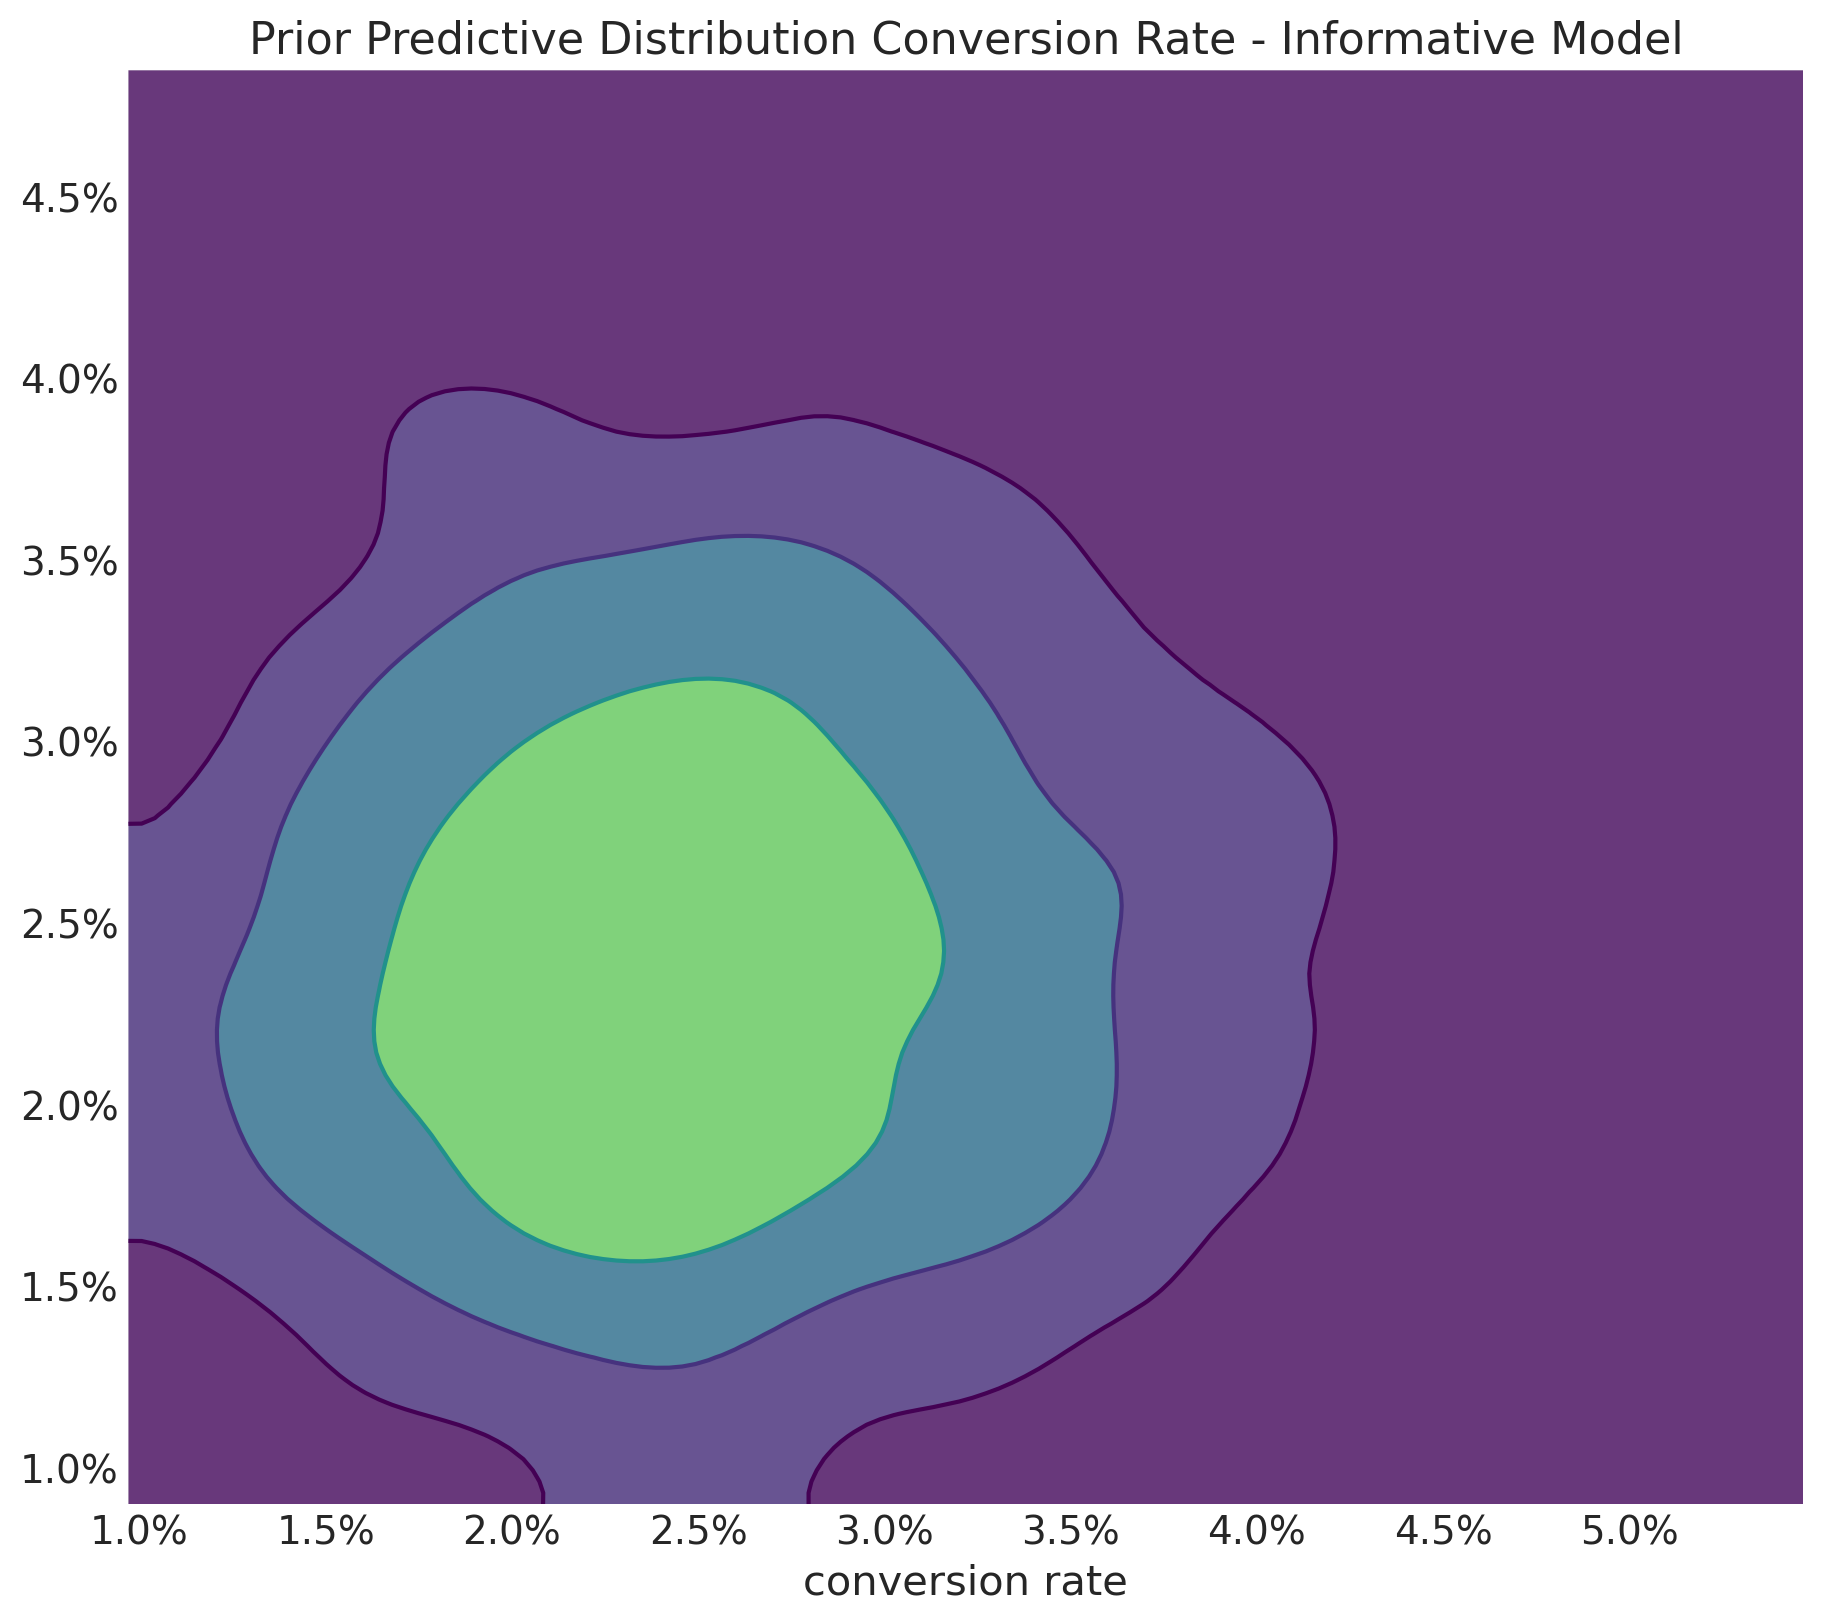

In [14]:
fig, ax = plt.subplots(figsize=(9, 8))
az.plot_dist(
    values=informative_prior_samples["prior"]["conversion_rate_control"],
    values2=informative_prior_samples["prior"]["conversion_rate_treatment"],
    contour_kwargs={"colors": None, "cmap": plt.cm.viridis},
    contourf_kwargs={"alpha": 0.8},
    ax=ax,
)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=1))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=1))
ax.set(
    title="Prior Predictive Distribution Conversion Rate - Informative Model",
    xlabel="conversion rate",
);

Well, this looks weird 🫠. It seems like a control and treatment combinations of $2.5\%$ and $1.5\%$ conversion rates is as likely as a control and treatment combinations being the same. I am sure we know this should not be the case. This unwanted expected effect is clearly seen in the prior predictive distribution of the relative lift: 

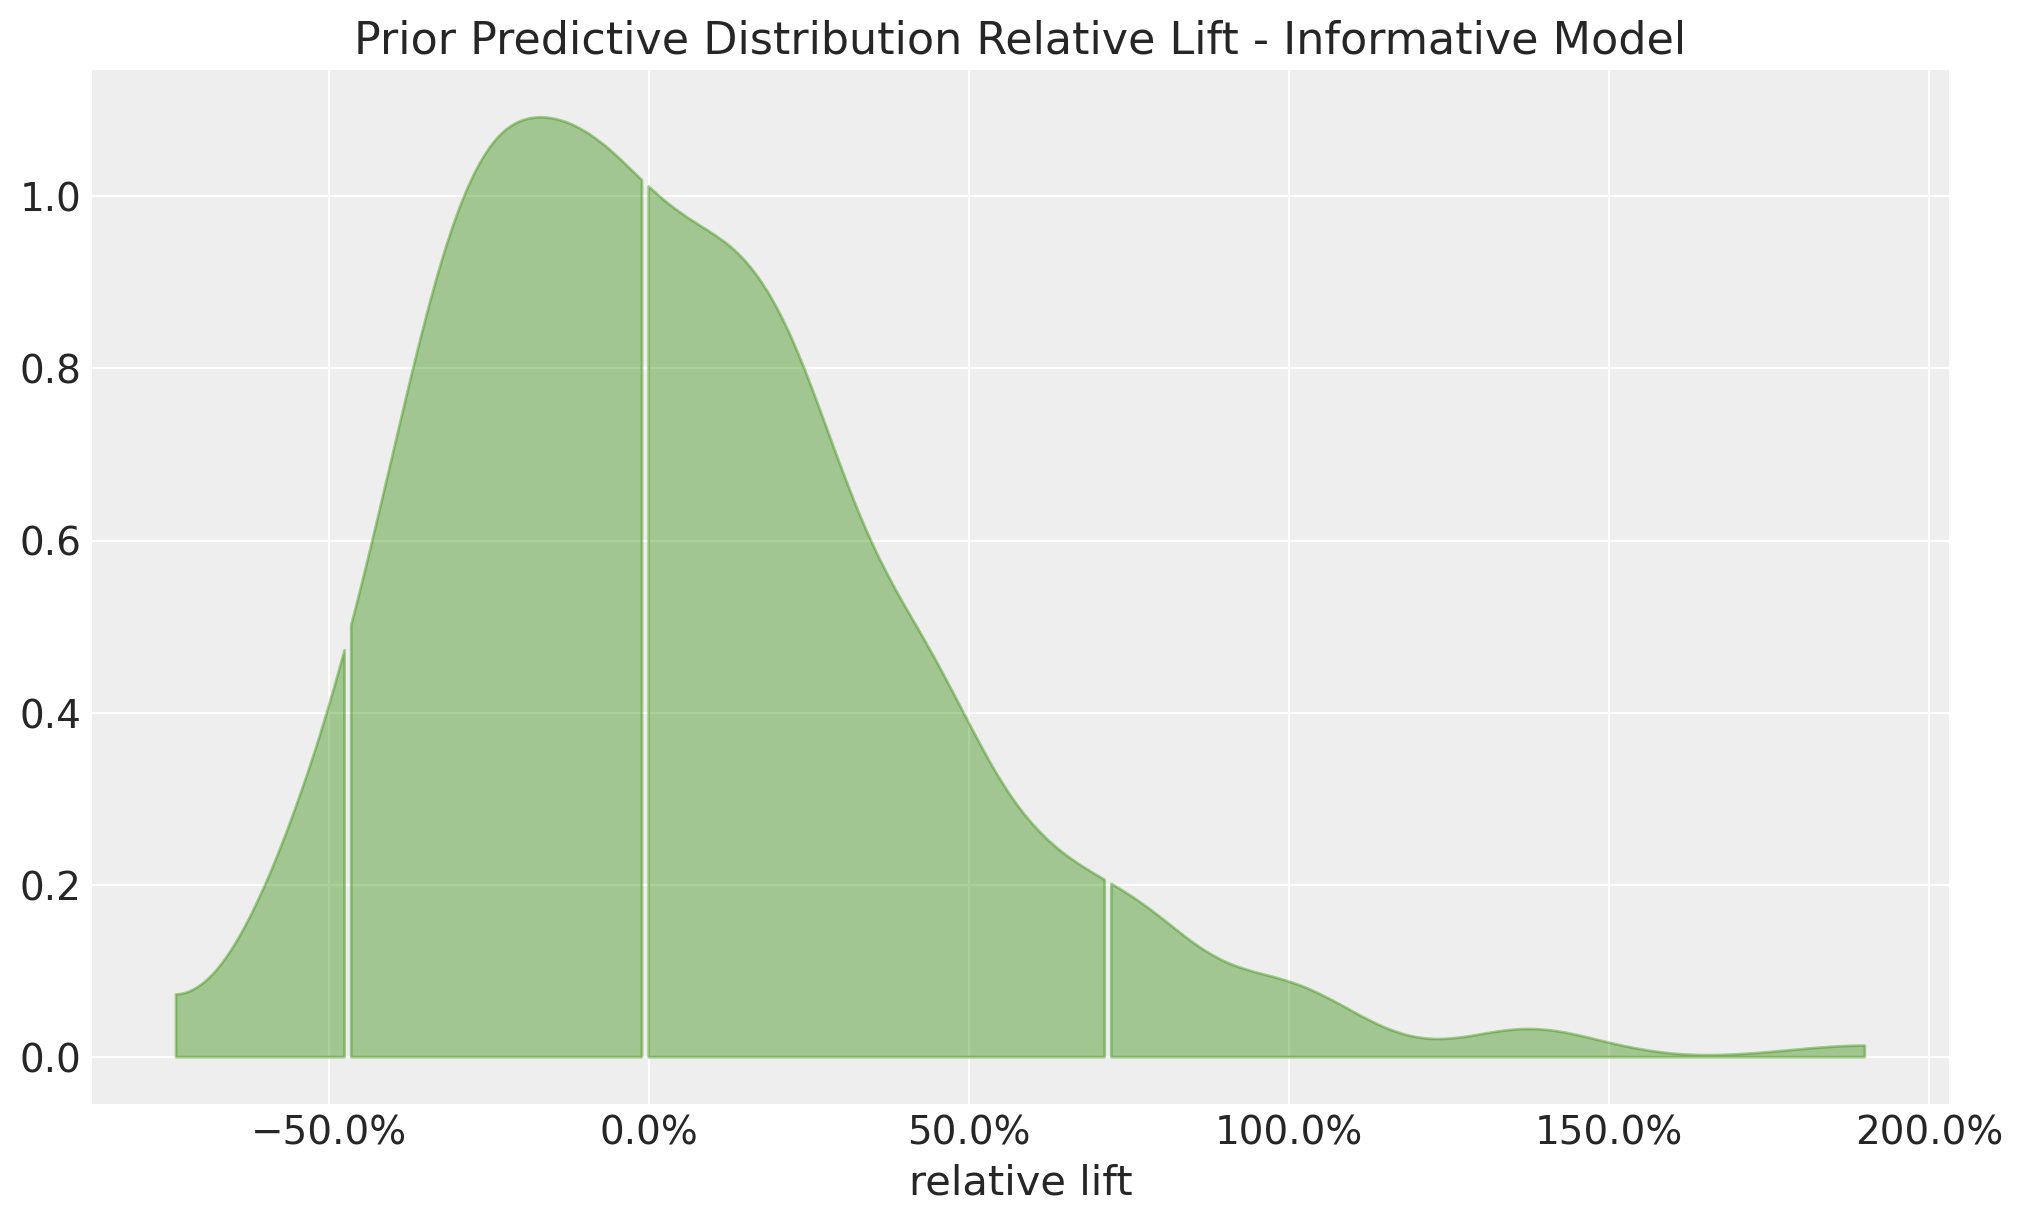

In [15]:
fig, ax = plt.subplots()
az.plot_dist(
    informative_prior_samples["prior"]["relative_lift"],
    color="C2",
    quantiles=[0.06, 0.5, 0.94],
    fill_kwargs={"alpha": 0.4},
    ax=ax,
)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=1))
ax.set(
    title="Prior Predictive Distribution Relative Lift - Informative Model",
    xlabel="relative lift",
);

This looks much better than the non-informative model. However, we still allow uplifts of $50\%$, which again seems very unlikely to happen in practice. As before, the share plot illustrates this point as well.

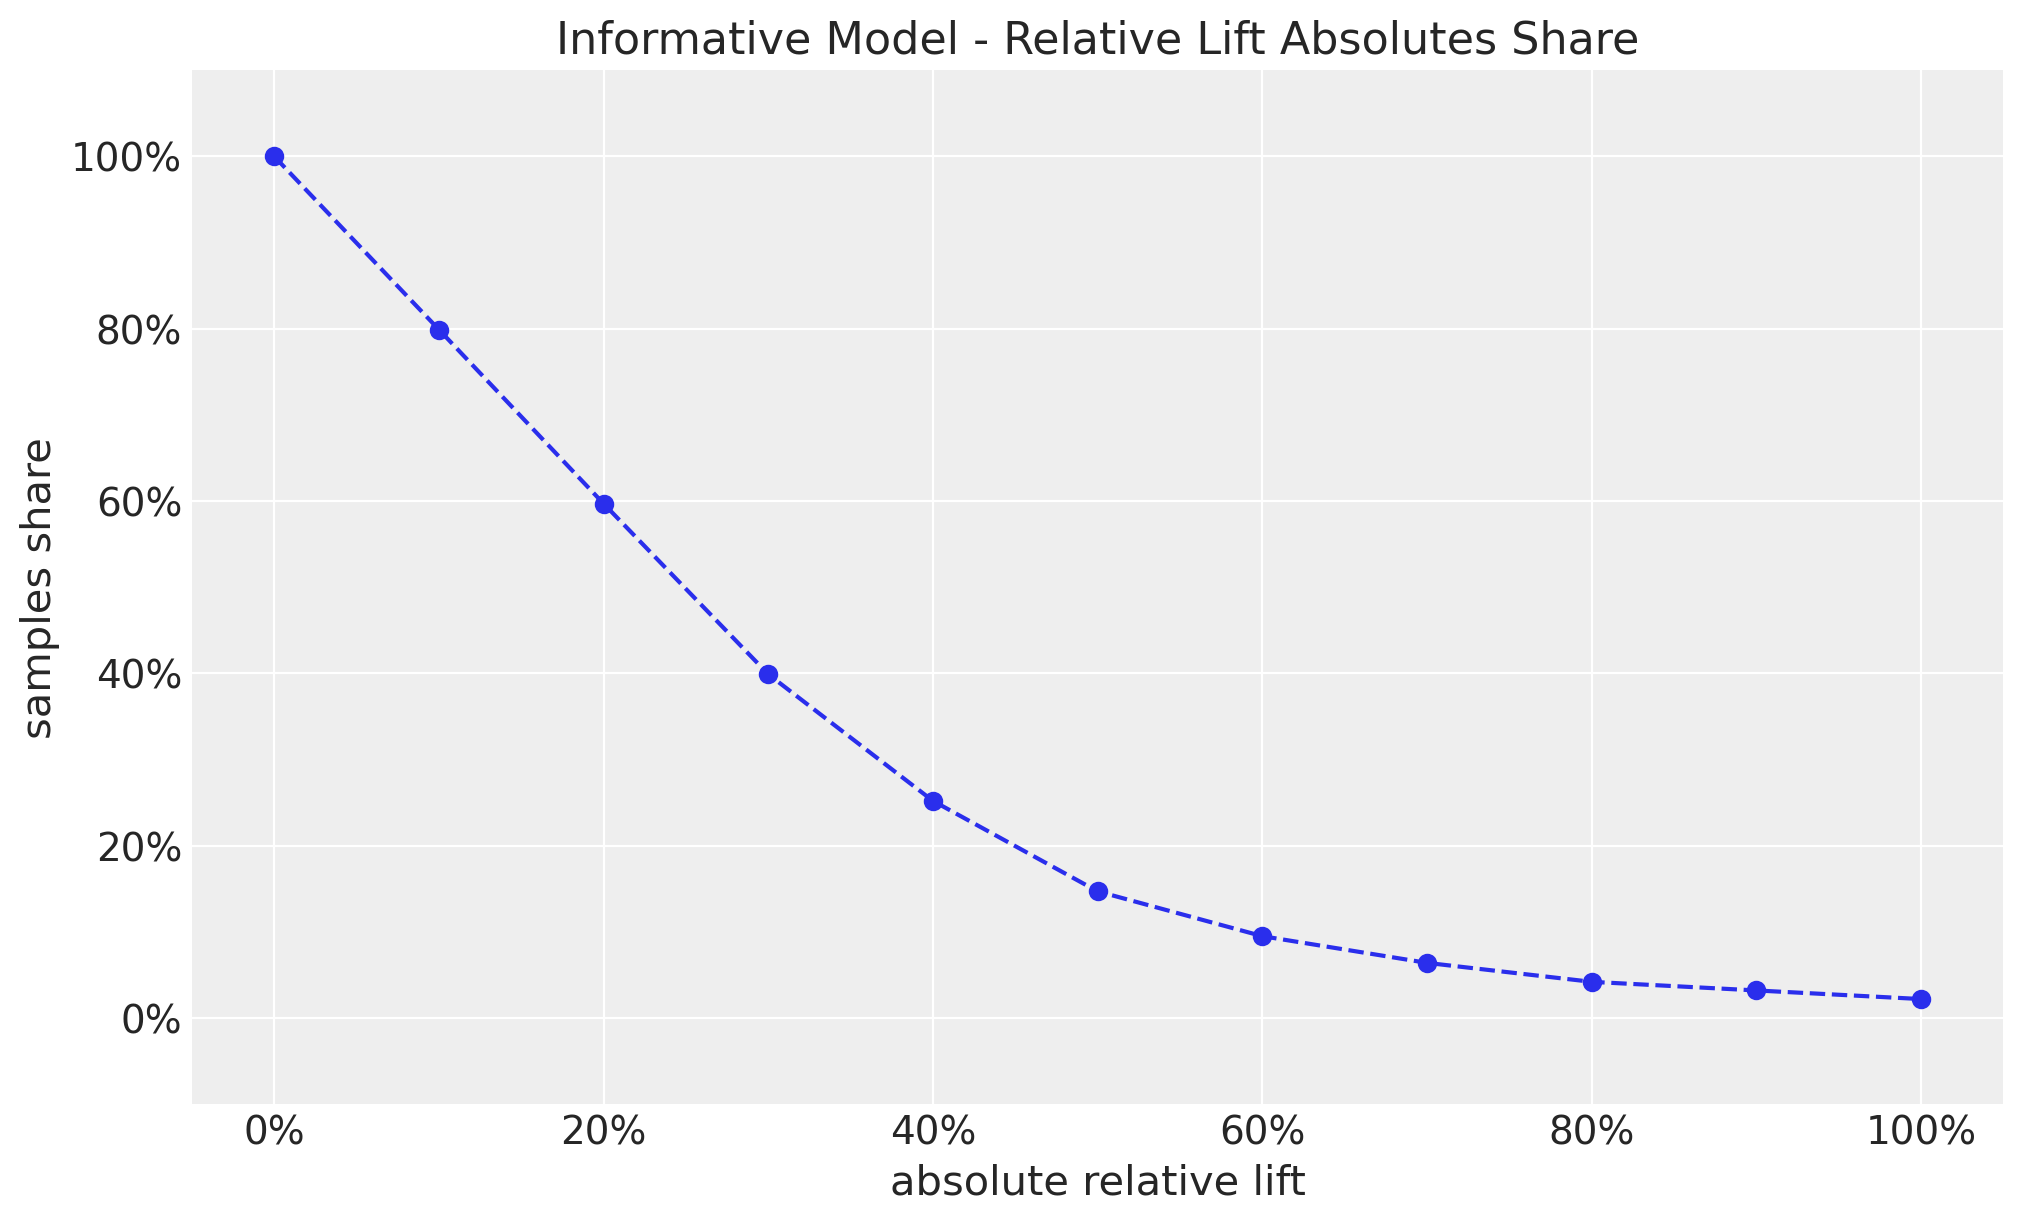

In [16]:
thresholds = np.linspace(start=0, stop=1, num=11)

shares = [
    (np.abs(informative_prior_samples["prior"]["relative_lift"]) >= threshold).mean()
    for threshold in thresholds
]

fig, ax = plt.subplots()
ax.plot(thresholds, shares, marker="o", linestyle="--", color="C0")
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))
ax.set(
    title="Informative Model - Relative Lift Absolutes Share",
    xlabel="absolute relative lift",
    ylabel="samples share",
    ylim=(-0.1, 1.1),
);

## Correlated Model

Can we do better? Yes, we can! From the blog post:

> *If we know the true conversion rate for the control group, we have a fairly confident sense of the conversion rate for the treatment group as well because we know that most true lifts are less than $10\%$.*

This suggest the key implementation trick: **we should set priors on the relative lift itself!**.

**Remark:** This actually reminds me of the ROAS parametrization in the context of media mix modeling: ["Media Mix Model Calibration With Bayesian Priors"](https://research.google/pubs/media-mix-model-calibration-with-bayesian-priors/) and ["Media Mix Model and Experimental Calibration: A Simulation Study"](https://juanitorduz.github.io/mmm_roas/).

We just need to tweak the model a little bit:

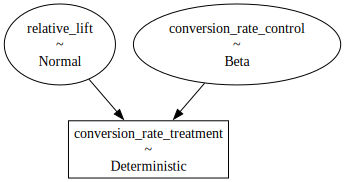

In [17]:
with pm.Model() as correlated_model:
    # Set a prior on the control conversion rate
    conversion_rate_control = pm.Beta("conversion_rate_control", alpha=15, beta=600)
    # Set a prior on the relative lift
    relative_lift = pm.Normal("relative_lift", mu=0, sigma=0.1)
    # Convert the relative lift to a conversion rate for the treatment
    # group deterministically
    conversion_rate_treatment = pm.Deterministic(
        "conversion_rate_treatment", conversion_rate_control * (1 + relative_lift)
    )

pm.model_to_graphviz(correlated_model)

With this approach we expect the conversion rates prior distributions are very similar to the informative model as the prior on the relative lift is centered around $0$.

In [18]:
with correlated_model:
    correlated_prior_samples = pm.sample_prior_predictive(
        samples=1_000, random_seed=rng
    )

Sampling: [conversion_rate_control, relative_lift]


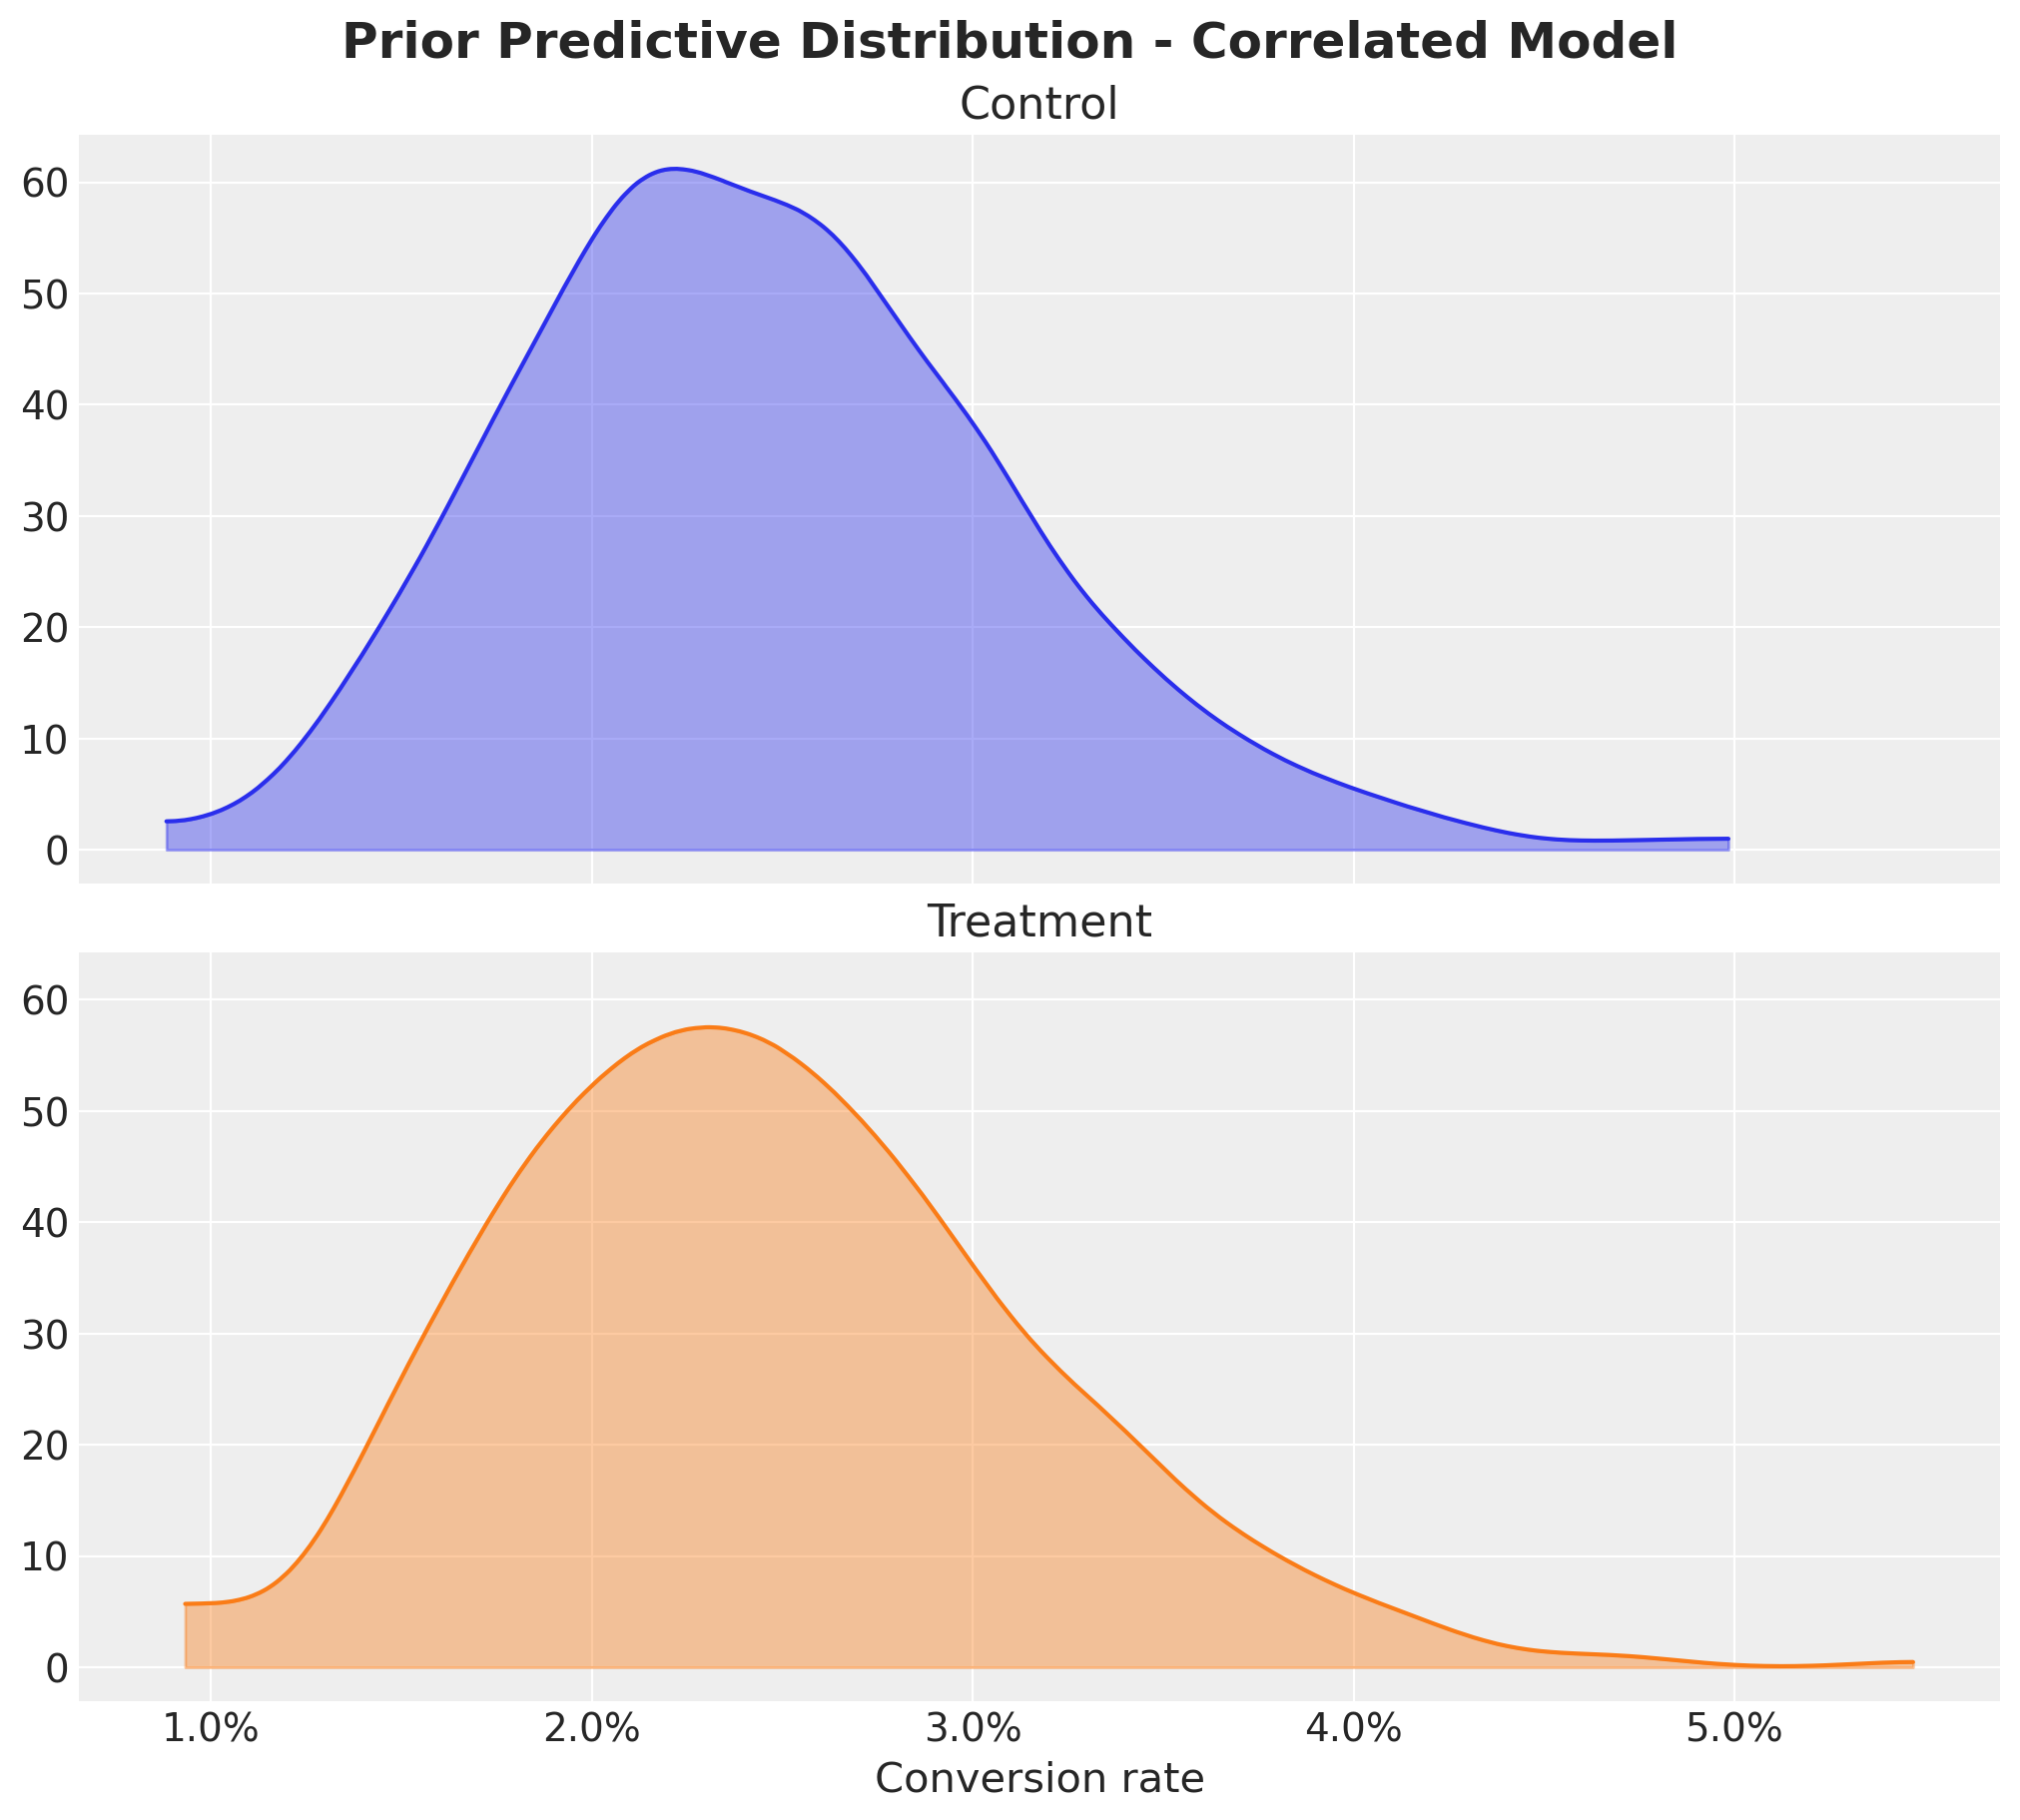

In [19]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(10, 9), sharex=True, sharey=True, layout="constrained"
)

az.plot_dist(
    correlated_prior_samples["prior"]["conversion_rate_control"],
    color="C0",
    fill_kwargs={"alpha": 0.4},
    ax=ax[0],
)
ax[0].set_title("Control")

az.plot_dist(
    correlated_prior_samples["prior"]["conversion_rate_treatment"],
    color="C1",
    fill_kwargs={"alpha": 0.4},
    ax=ax[1],
)
ax[1].set(title="Treatment", xlabel="Conversion rate")
ax[1].xaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=1))
fig.suptitle(
    "Prior Predictive Distribution - Correlated Model", fontsize=18, fontweight="bold"
);

We do see the range of conversion rates as expected 🙌.

Now, we look at the joint distribution of the conversion rates:

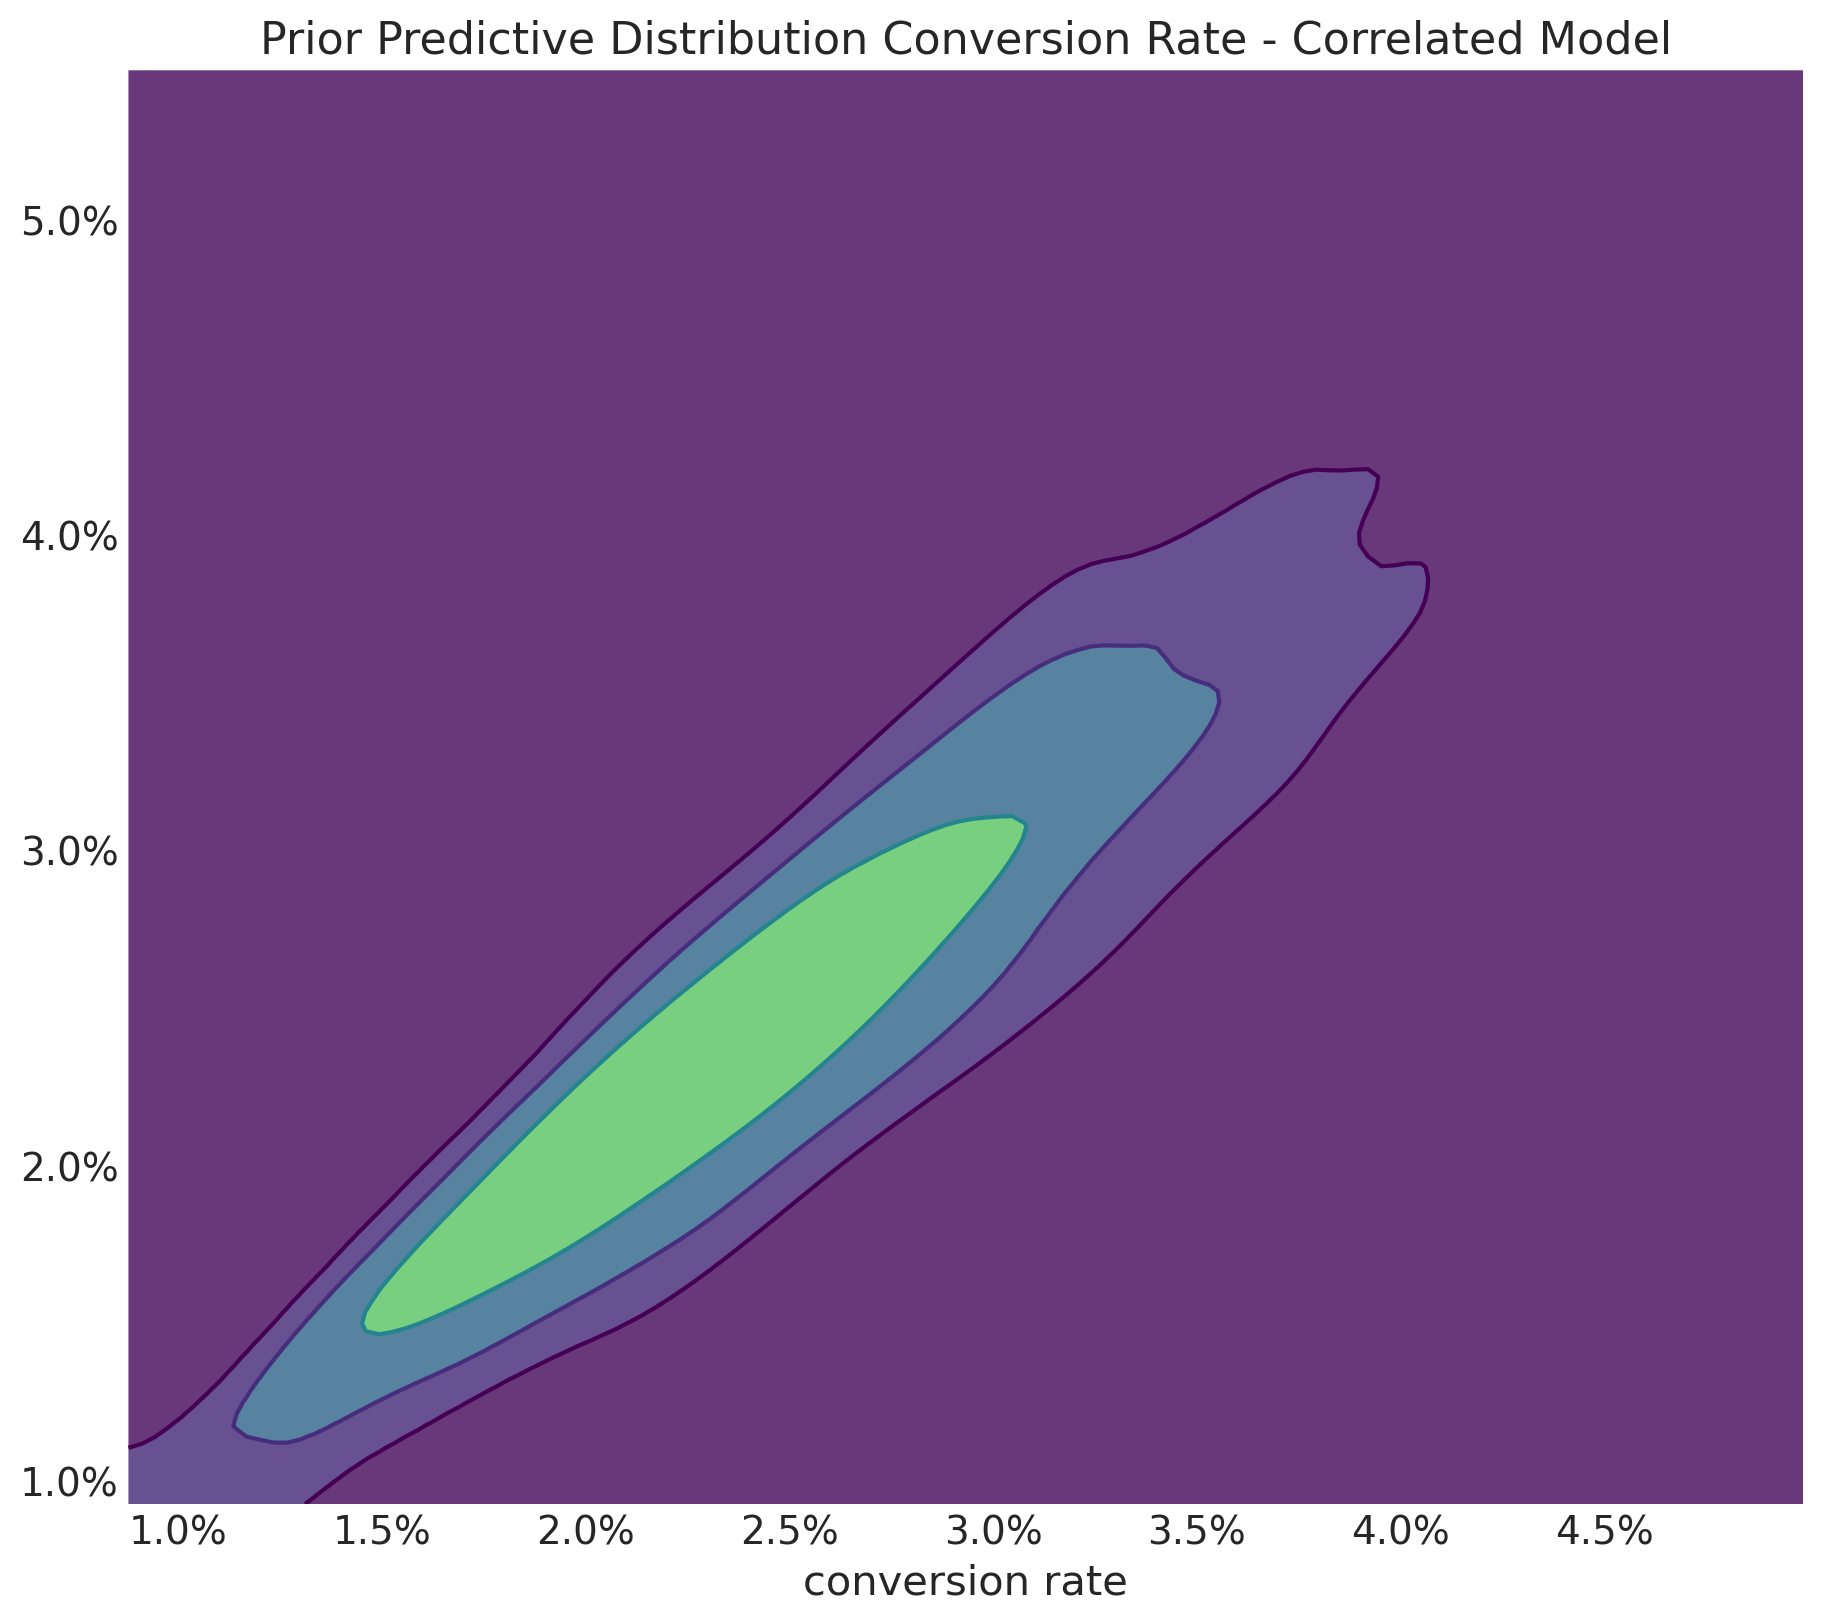

In [20]:
fig, ax = plt.subplots(figsize=(9, 8))
az.plot_dist(
    values=correlated_prior_samples["prior"]["conversion_rate_control"],
    values2=correlated_prior_samples["prior"]["conversion_rate_treatment"],
    contour_kwargs={"colors": None, "cmap": plt.cm.viridis},
    contourf_kwargs={"alpha": 0.8},
    ax=ax,
)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=1))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=1))
ax.set(
    title="Prior Predictive Distribution Conversion Rate - Correlated Model",
    xlabel="conversion rate",
);

This looks much better! The joint distribution is concentrated around the diagonal, which is what we want (this is exactly the key point of the blog post) 🎉.

Finally, let's look at the prior predictive distribution of the relative lift (which we set explicitly)

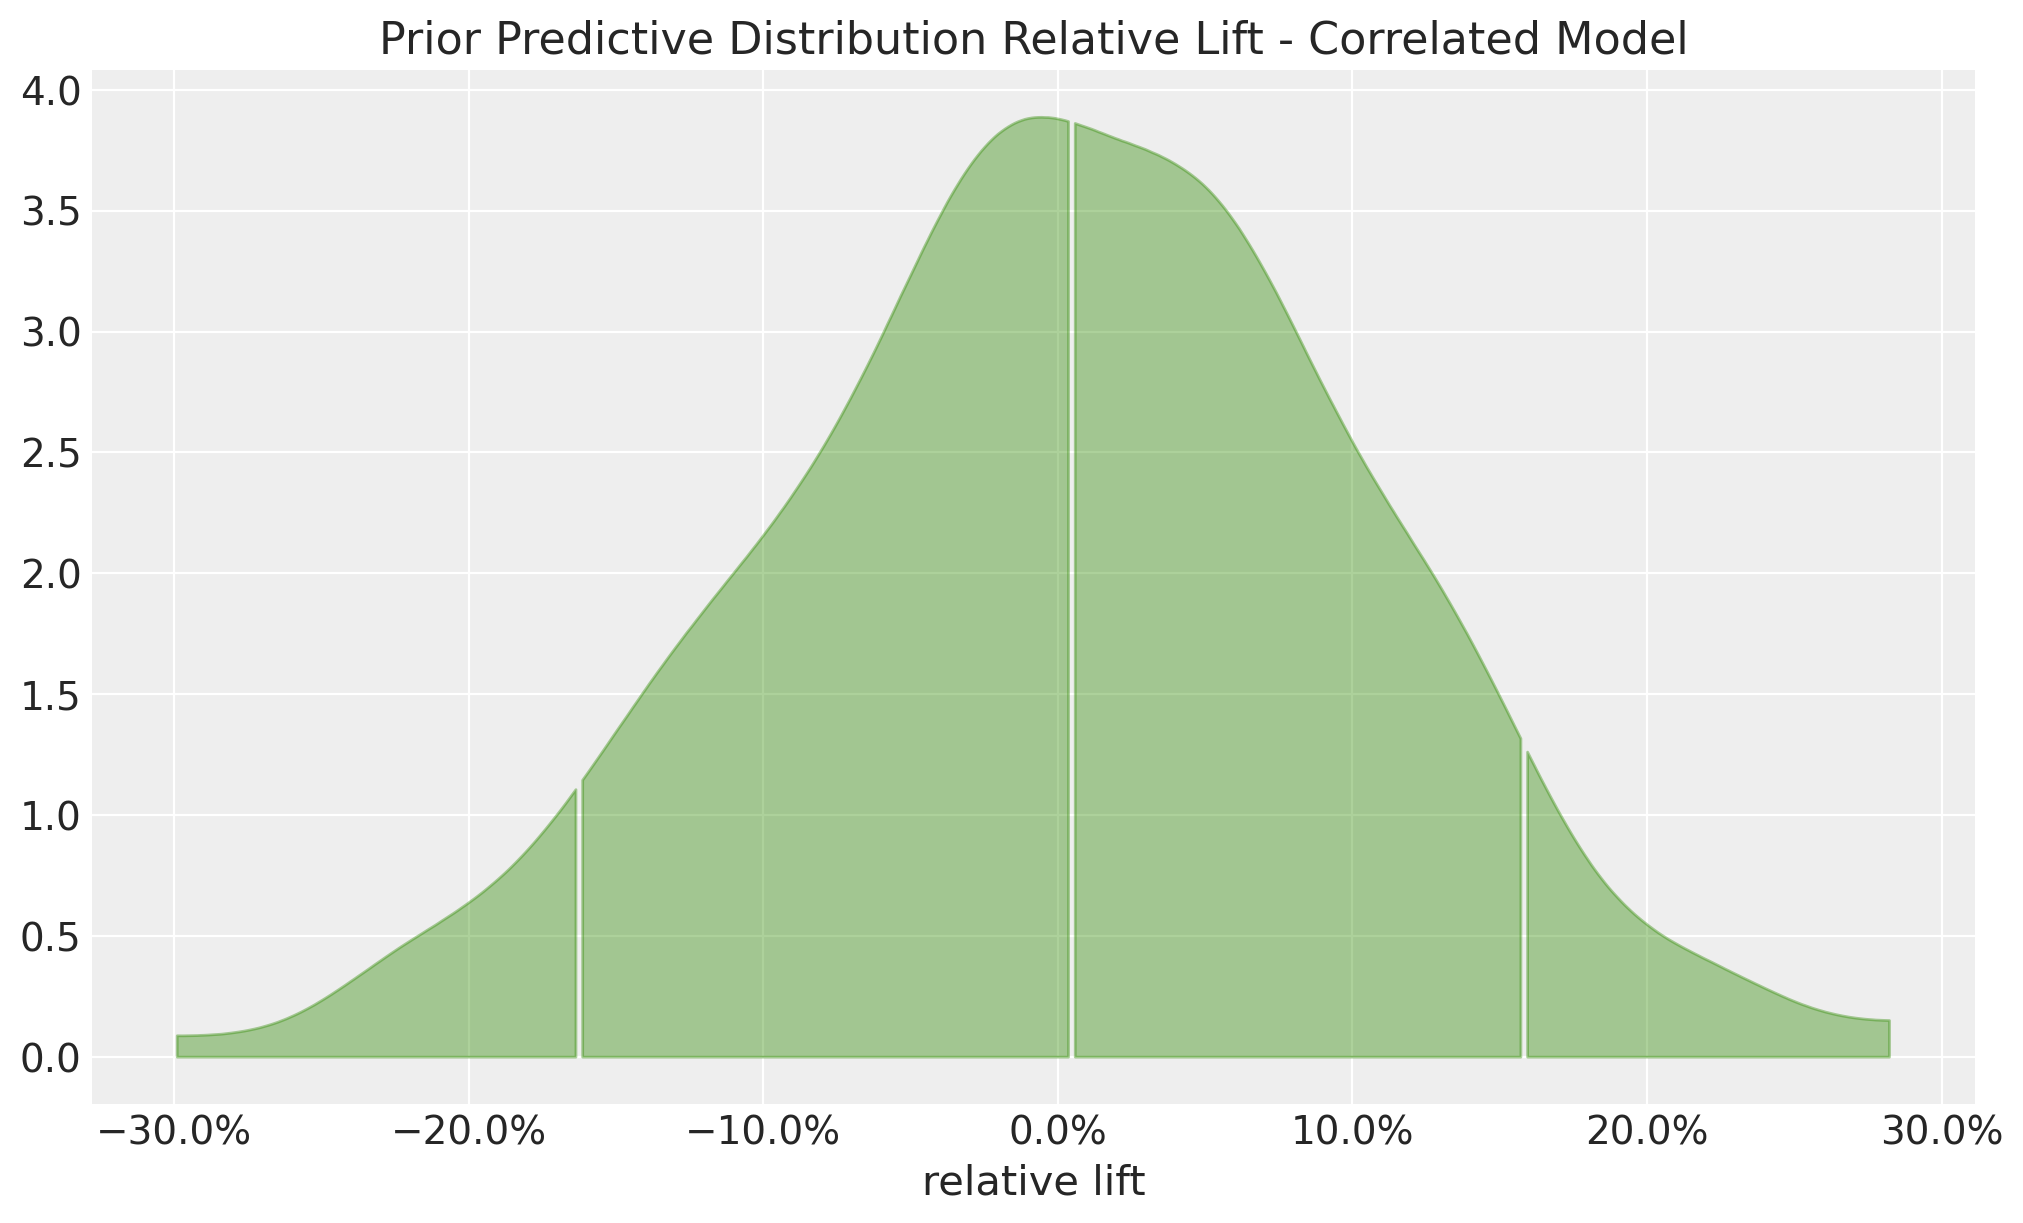

In [21]:
fig, ax = plt.subplots()
az.plot_dist(
    correlated_prior_samples["prior"]["relative_lift"],
    color="C2",
    quantiles=[0.06, 0.5, 0.94],
    fill_kwargs={"alpha": 0.4},
    ax=ax,
)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=1))
ax.set(
    title="Prior Predictive Distribution Relative Lift - Correlated Model",
    xlabel="relative lift",
);

This is nothing as the prior $\text{Normal}(0, 0.1)$.

The share plot also shows how constrained our relative lifts are now.

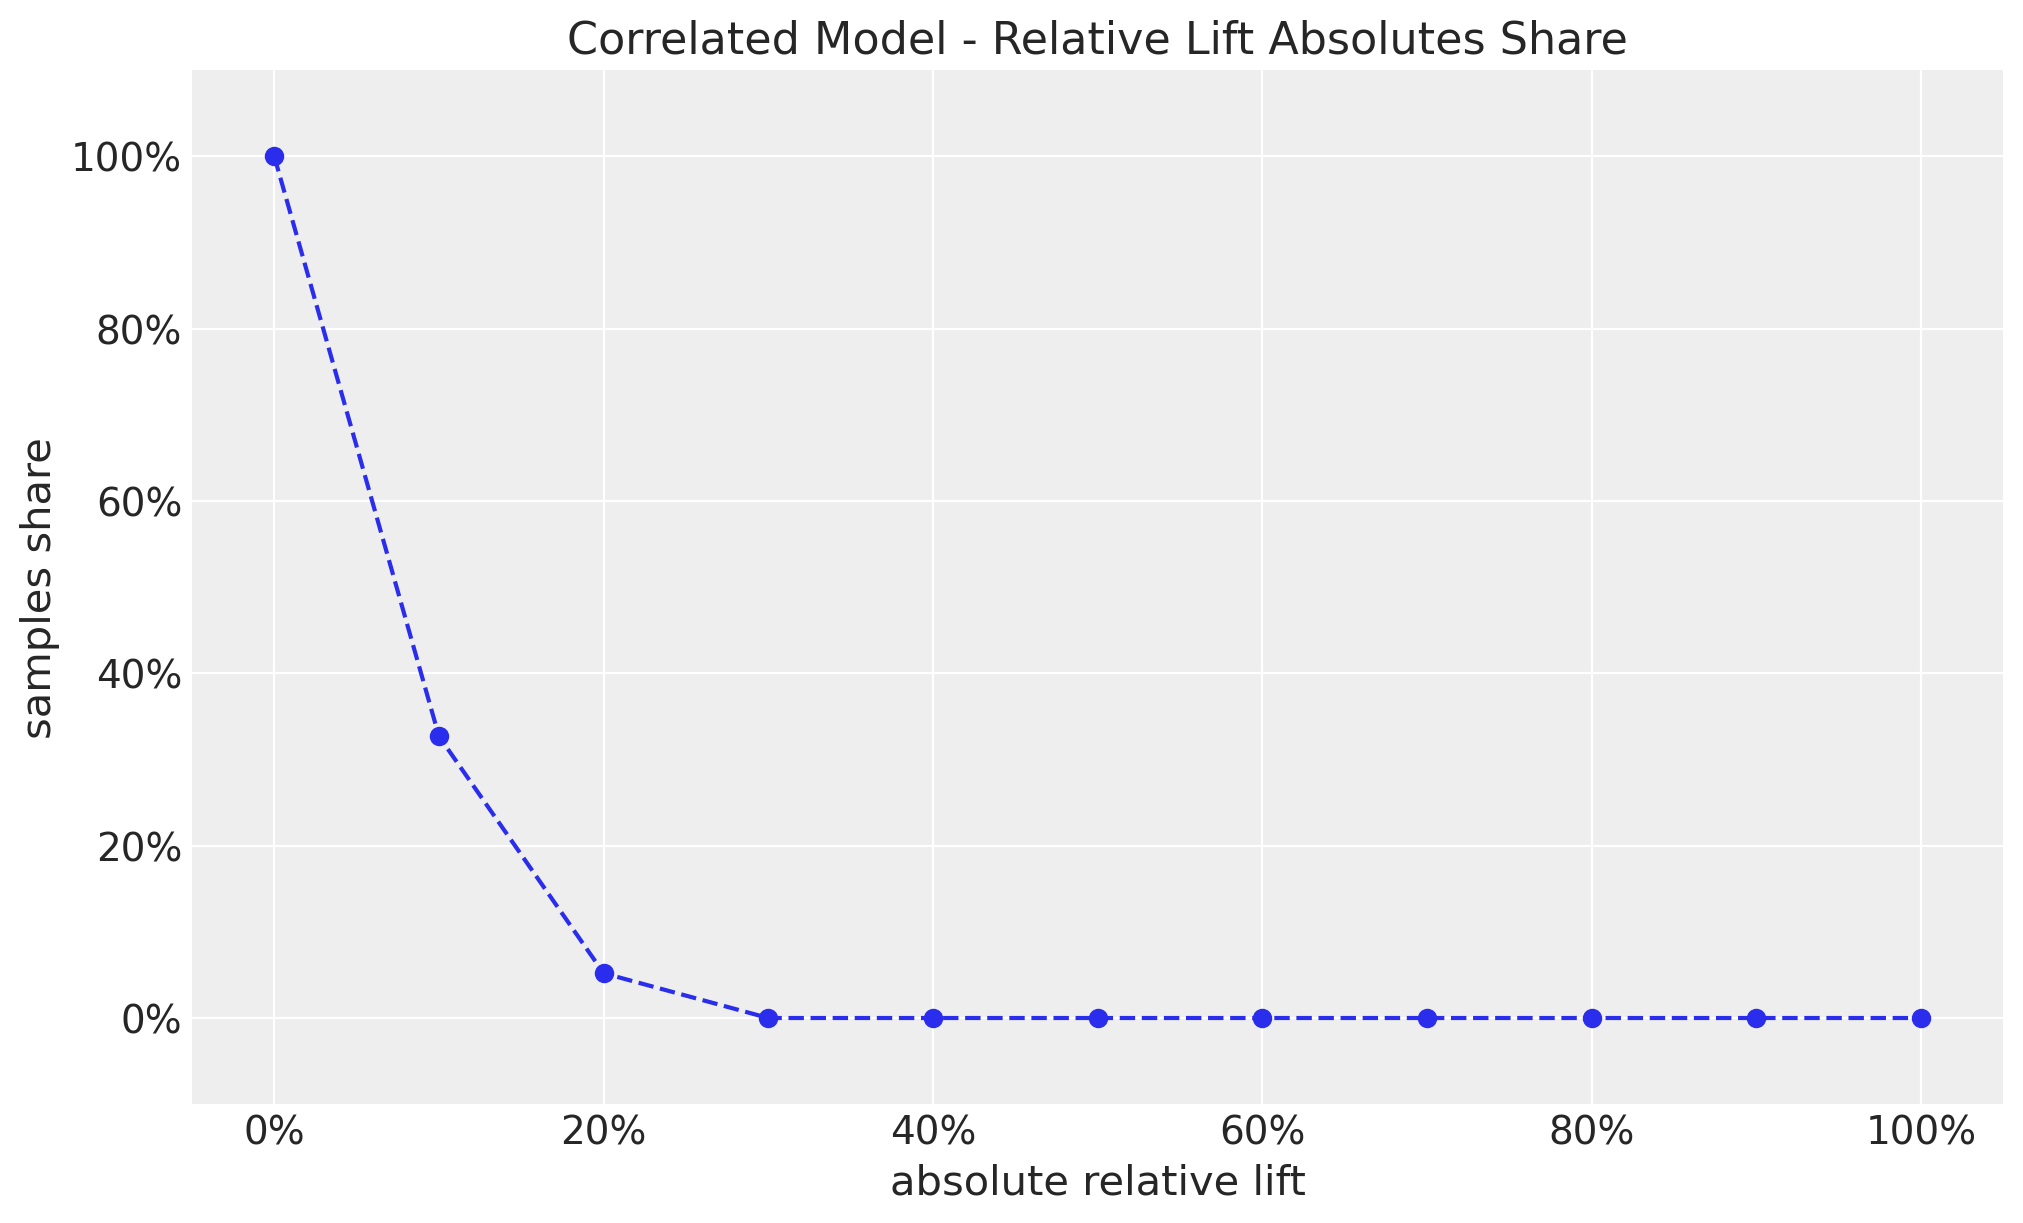

In [22]:
thresholds = np.linspace(start=0, stop=1, num=11)

shares = [
    (np.abs(correlated_prior_samples["prior"]["relative_lift"]) >= threshold).mean()
    for threshold in thresholds
]

fig, ax = plt.subplots()
ax.plot(thresholds, shares, marker="o", linestyle="--", color="C0")
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))
ax.set(
    title="Correlated Model - Relative Lift Absolutes Share",
    xlabel="absolute relative lift",
    ylabel="samples share",
    ylim=(-0.1, 1.1),
);

## Model Comparison

To summarize and compare the models, we can plot the prior predictive distribution of the relative lift for all models.

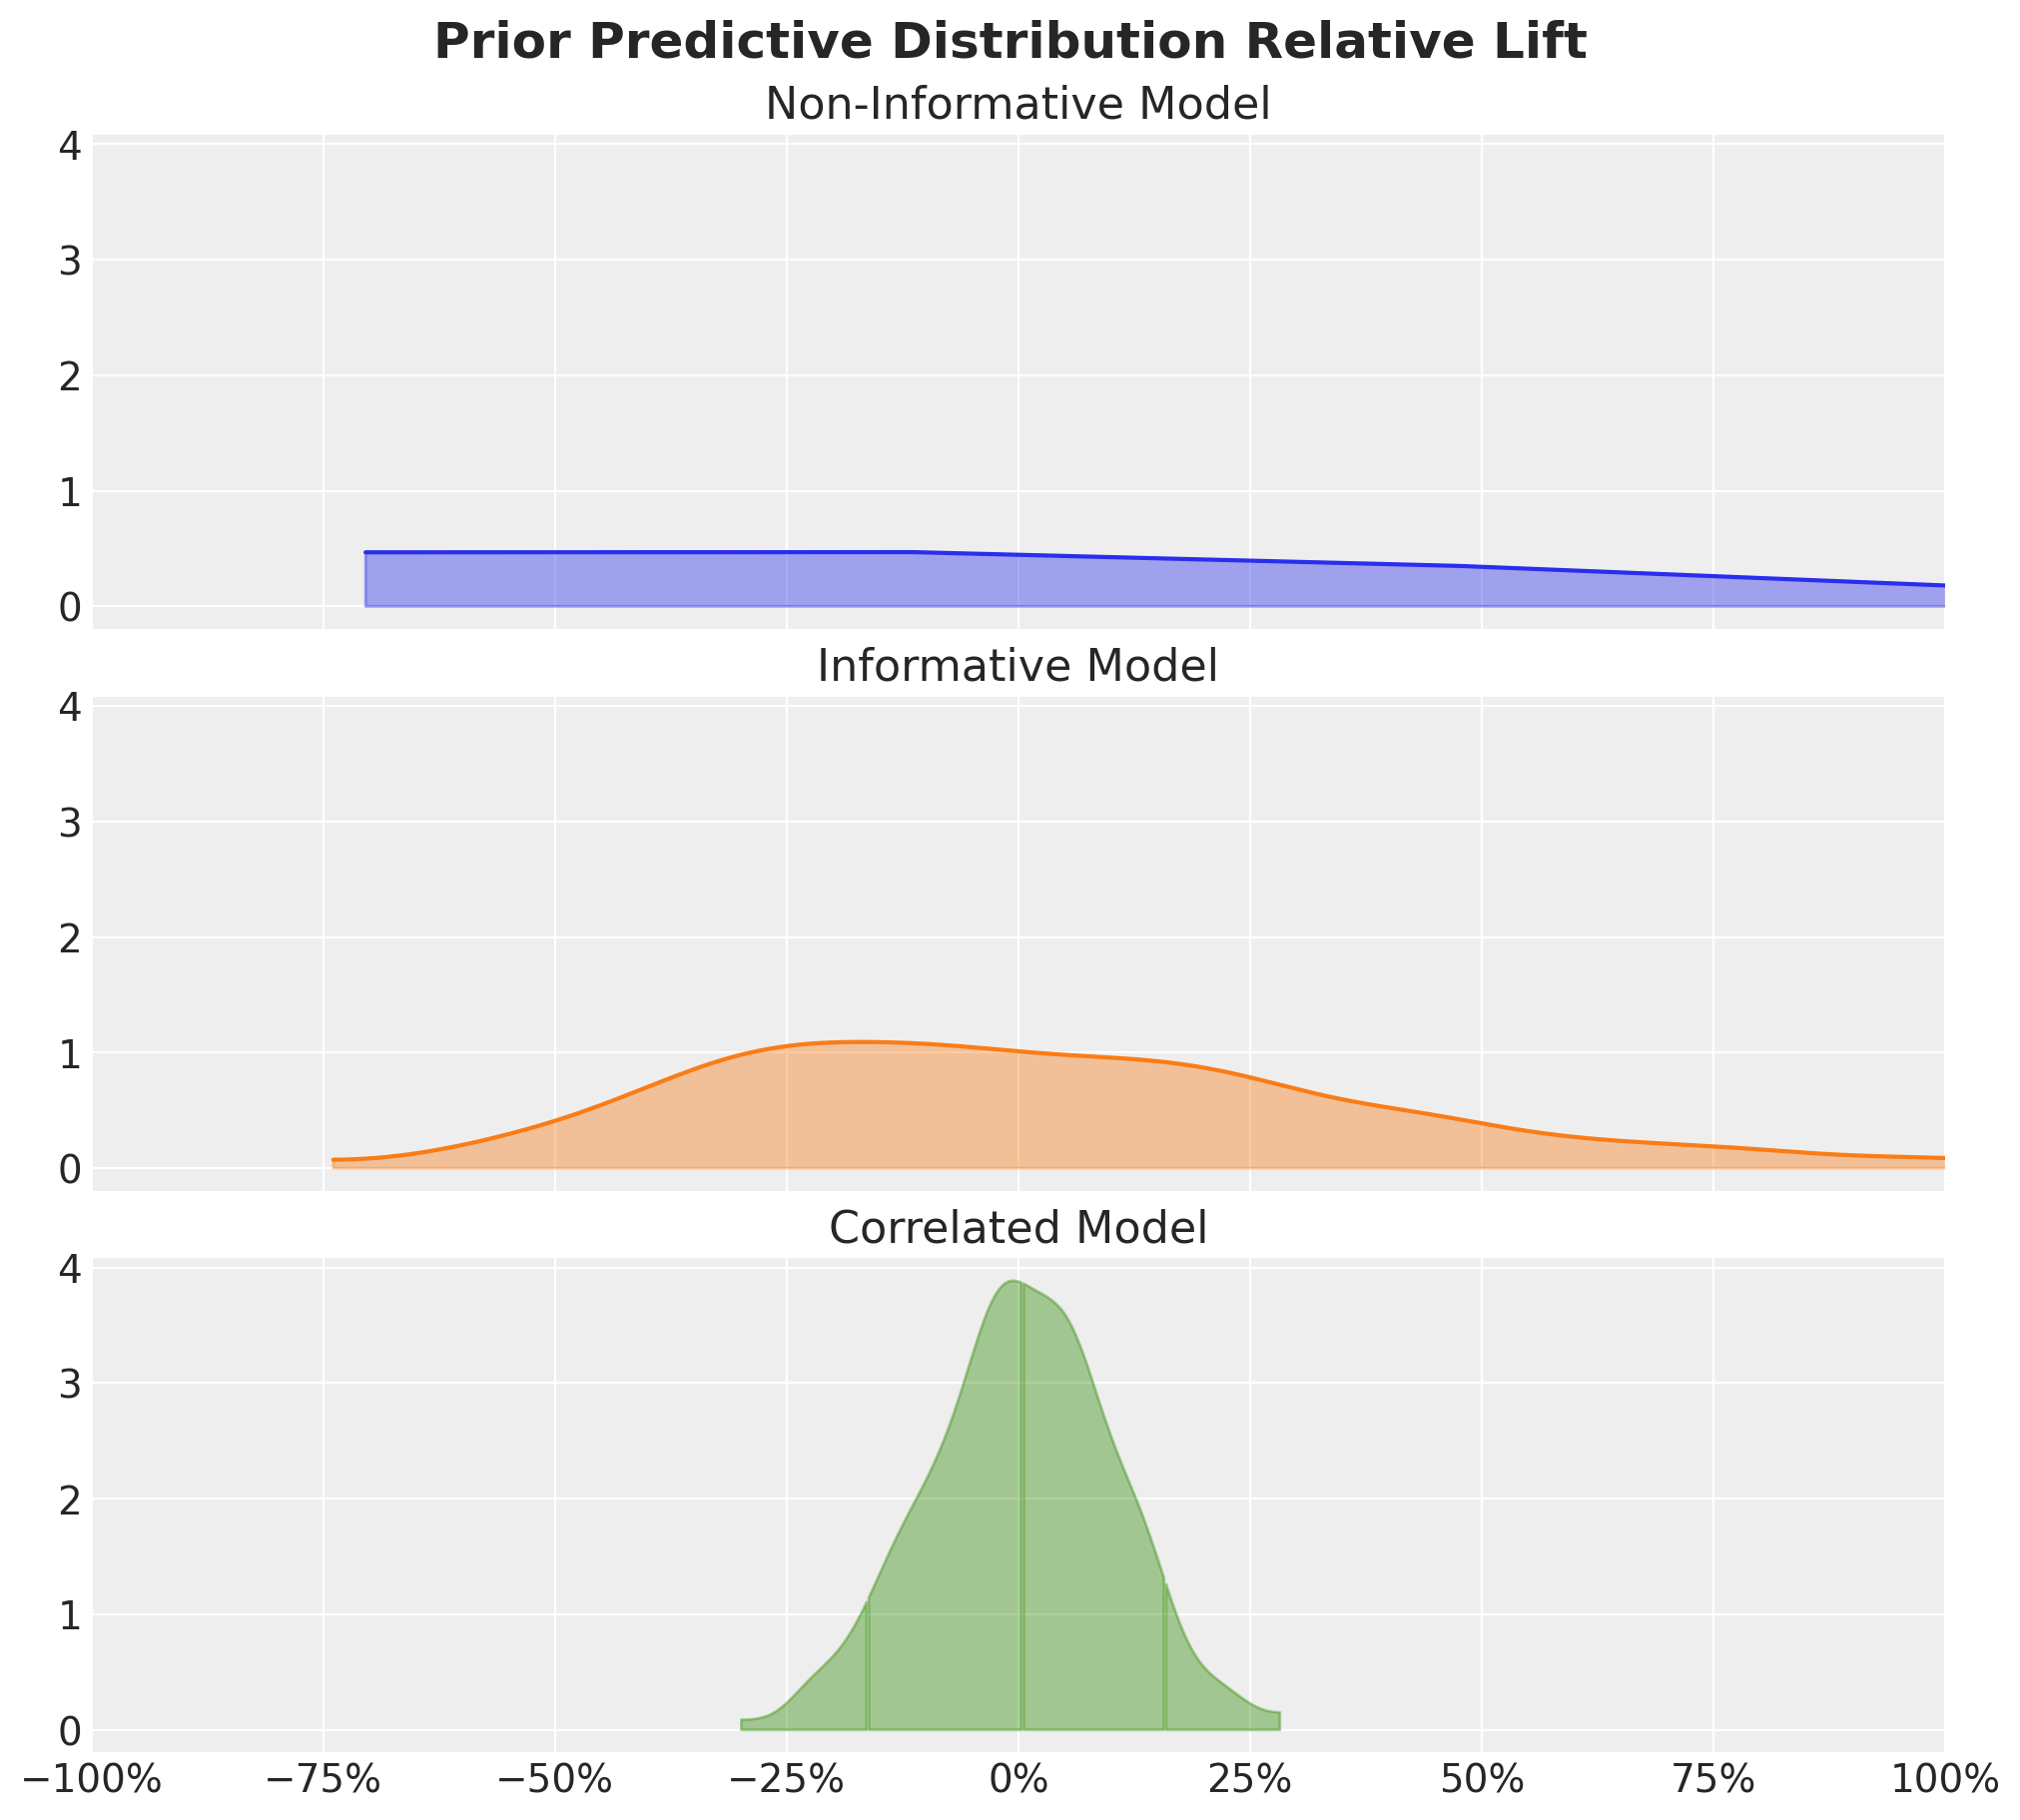

In [23]:
fig, ax = plt.subplots(
    nrows=3, ncols=1, figsize=(10, 9), sharex=True, sharey=True, layout="constrained"
)

az.plot_dist(
    non_informative_prior_samples["prior"]["relative_lift"],
    color="C0",
    fill_kwargs={"alpha": 0.4},
    ax=ax[0],
)
ax[0].set(title="Non-Informative Model")

az.plot_dist(
    informative_prior_samples["prior"]["relative_lift"],
    color="C1",
    fill_kwargs={"alpha": 0.4},
    ax=ax[1],
)
ax[1].set(title="Informative Model")

az.plot_dist(
    correlated_prior_samples["prior"]["relative_lift"],
    color="C2",
    quantiles=[0.06, 0.5, 0.94],
    fill_kwargs={"alpha": 0.4},
    ax=ax[2],
)
ax[2].set(title="Correlated Model", xlim=(-1, 1))
ax[2].xaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))

fig.suptitle(
    "Prior Predictive Distribution Relative Lift", fontsize=18, fontweight="bold"
);

The key point to take is that informative priors on the conversion rates lead to locally "flat" prior predictive distributions of the relative lift, which is not what we want.

## Inference

Lastly, to close the loop, we can run inference assuming we have observed data.

In [24]:
# Observed Data
n = 10_000
n_control = 200
n_treatment = 350

In [25]:
empirical_uplift = (n_treatment / n_control) - 1
empirical_uplift

0.75

We need to condition the model on the observed data using a Binomial likelihood.

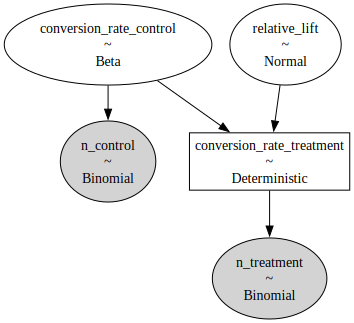

In [26]:
with correlated_model:
    pm.Binomial("n_control", n=n, p=conversion_rate_control, observed=n_control)
    pm.Binomial("n_treatment", n=n, p=conversion_rate_treatment, observed=n_treatment)

pm.model_to_graphviz(correlated_model)

Now we sample from the posterior distribution.

In [27]:
with correlated_model:
    correlated_posterior_samples = pm.sample(draws=1_000, chains=4, random_seed=rng)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [conversion_rate_control, relative_lift]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.


Let's look at the results:

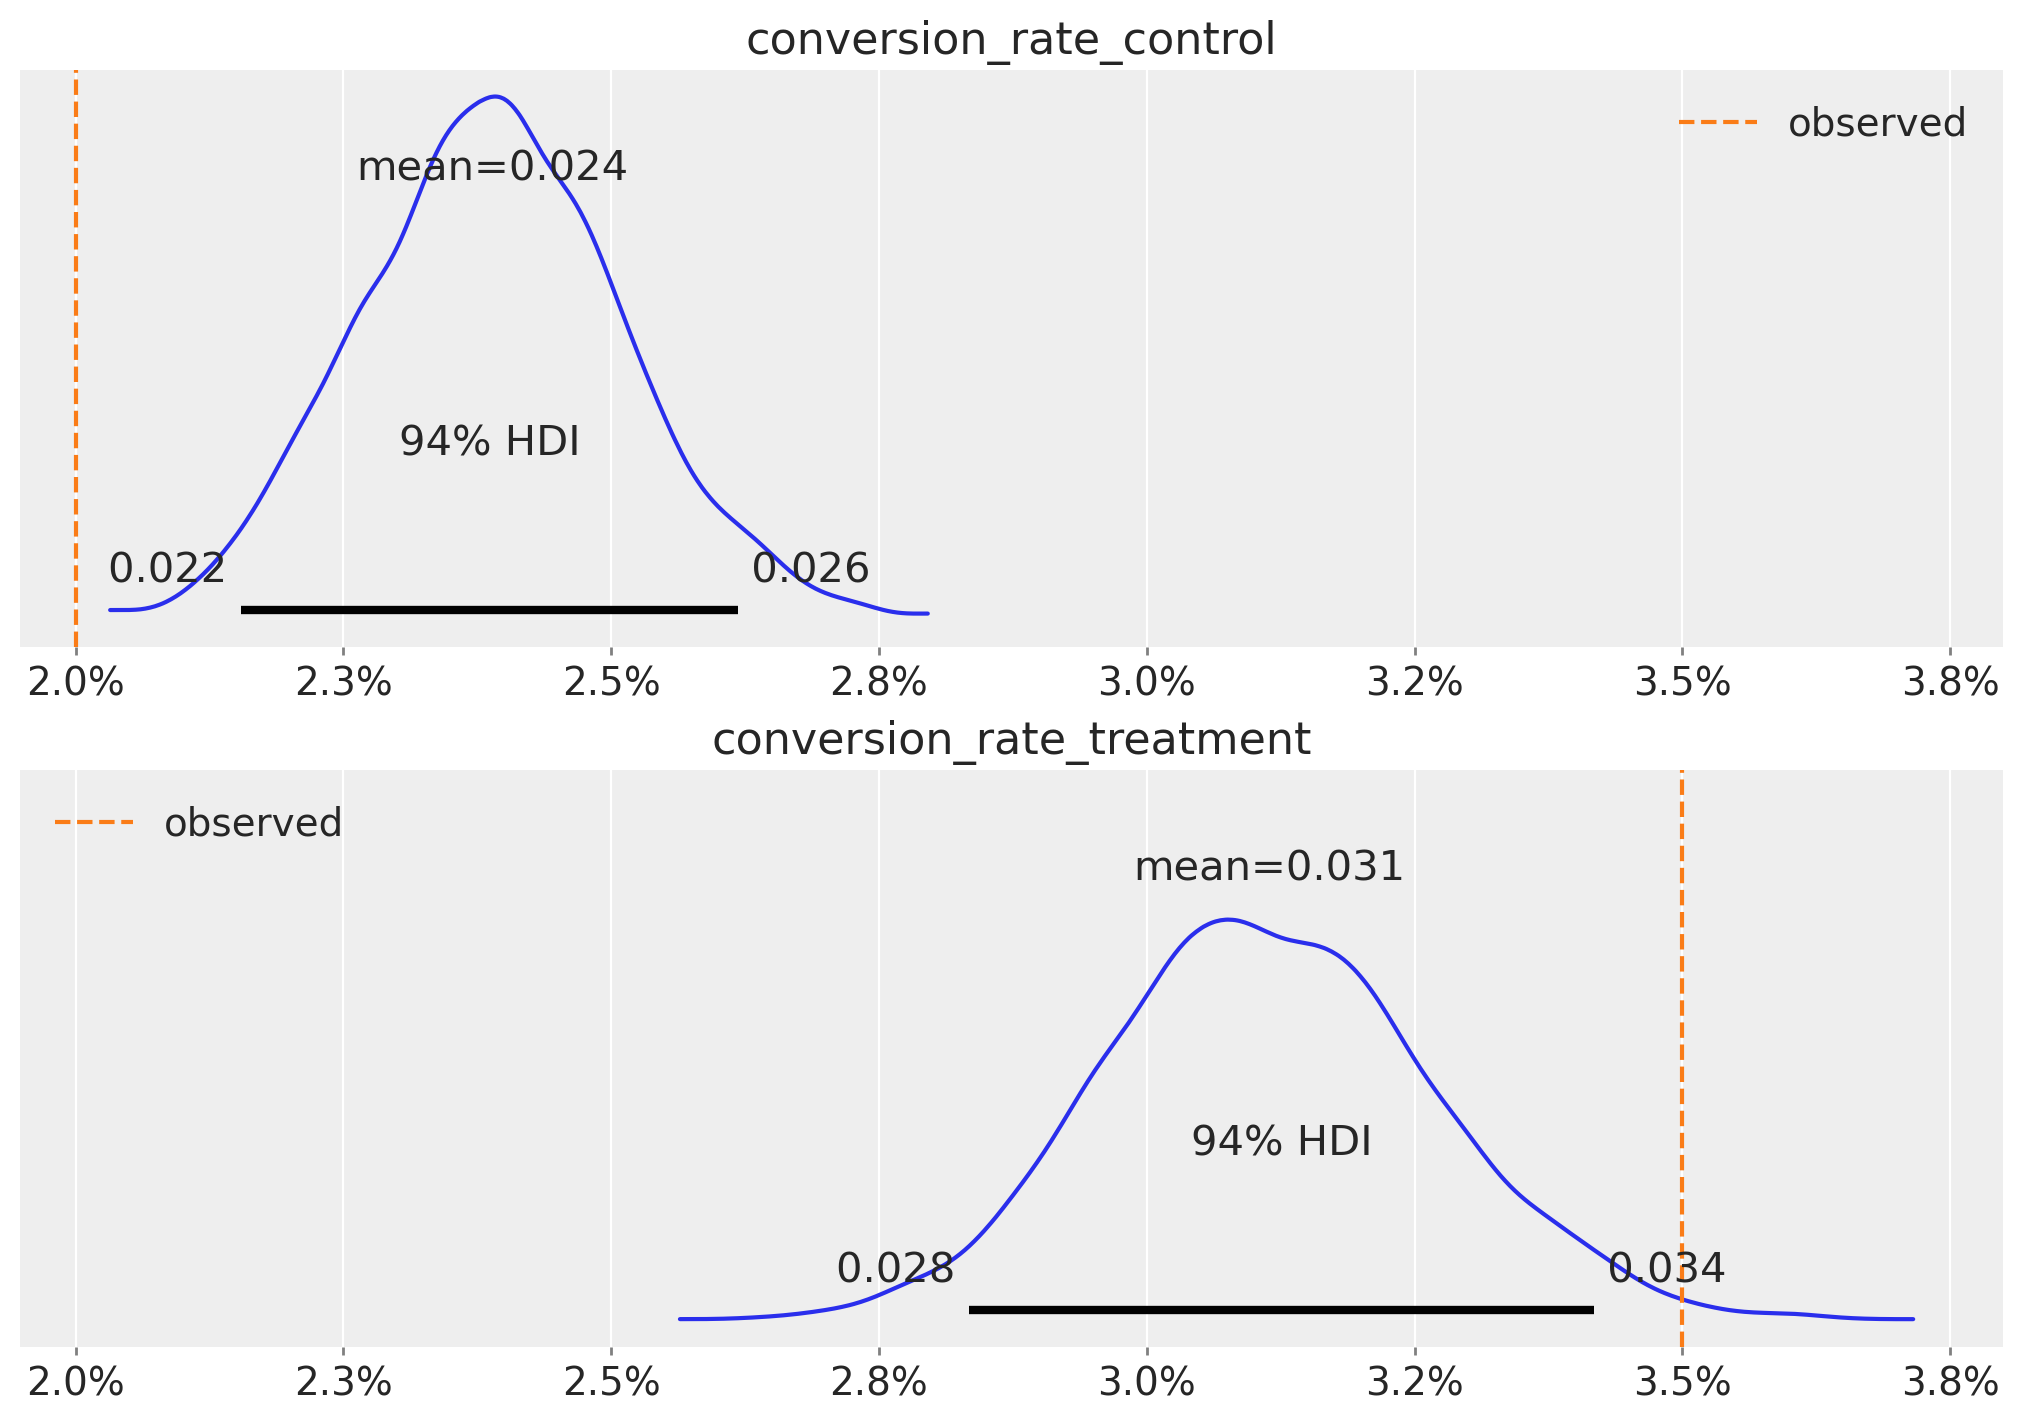

In [28]:
fig, axes = plt.subplots(
    nrows=2, ncols=1, figsize=(10, 7), sharex=True, sharey=True, layout="constrained"
)

az.plot_posterior(
    correlated_posterior_samples,
    var_names=[
        "conversion_rate_control",
        "conversion_rate_treatment",
    ],
    ax=axes,
)

for i, ax in enumerate(axes):
    obs = n_control / n if i == 0 else n_treatment / n
    ax.axvline(x=obs, color="C1", linestyle="--", label="observed")
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=1))
    ax.legend()

We see that the posterior distributions are shrinked around the prior, which is acting as a type of regularization.

The joint posterior distribution of looks slightly correlated but do not let you fool by the plot, note that the support is very concentrated.

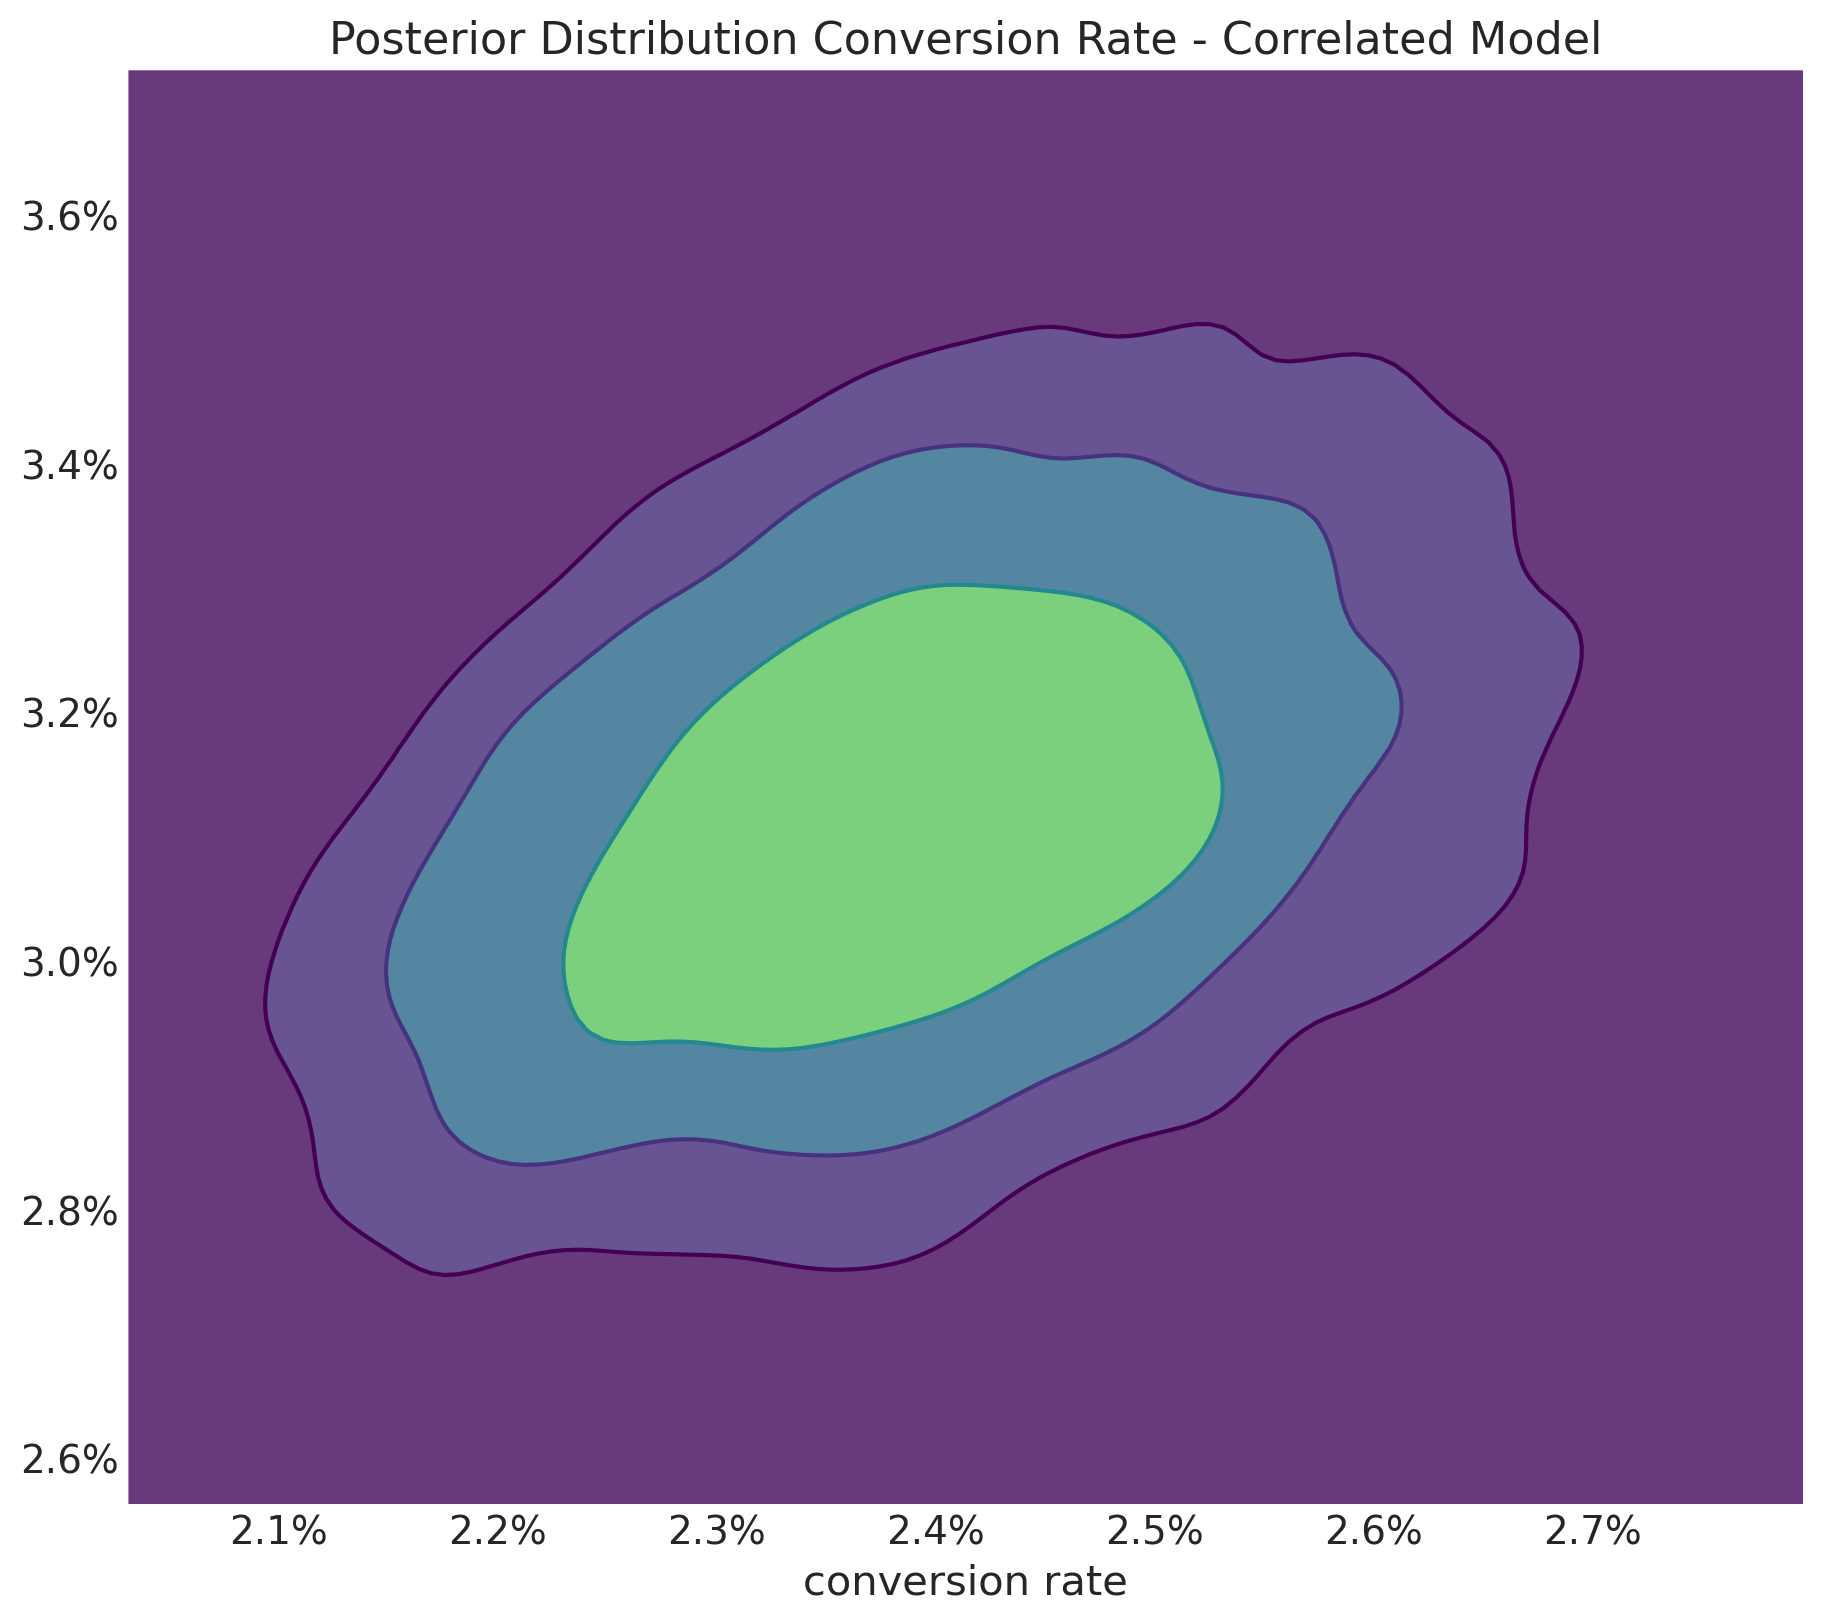

In [29]:
fig, ax = plt.subplots(figsize=(9, 8))
az.plot_dist(
    values=correlated_posterior_samples["posterior"]["conversion_rate_control"],
    values2=correlated_posterior_samples["posterior"]["conversion_rate_treatment"],
    contour_kwargs={"colors": None, "cmap": plt.cm.viridis},
    contourf_kwargs={"alpha": 0.8},
    ax=ax,
)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=1))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=1))
ax.set(
    title="Posterior Distribution Conversion Rate - Correlated Model",
    xlabel="conversion rate",
);

Next, we look at the posterior distribution of the relative lift:

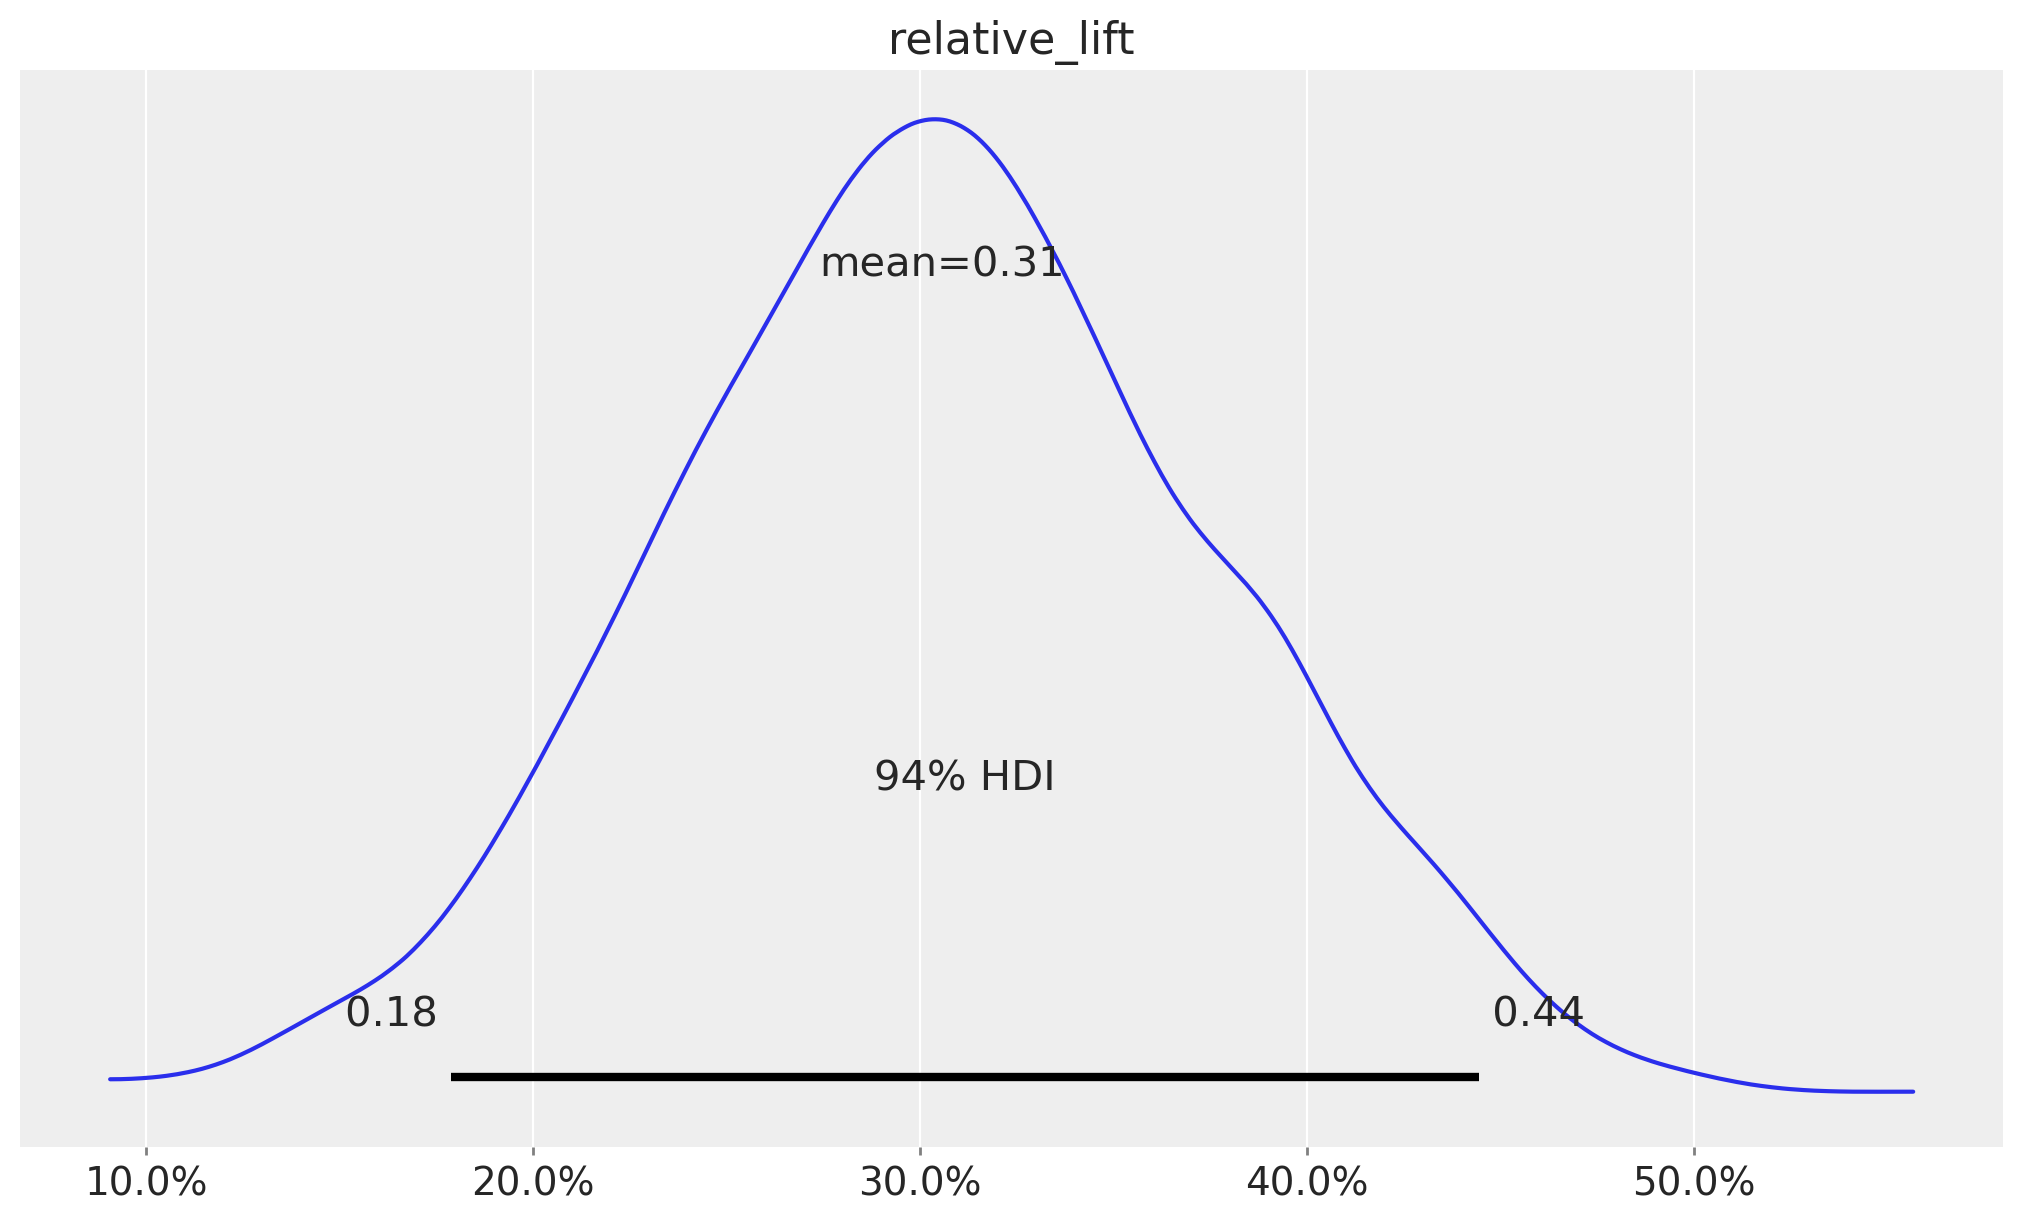

In [30]:
ax = az.plot_posterior(
    correlated_posterior_samples,
    var_names=["relative_lift"],
)

ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=1));

We see it is a much more conservative estimate than then observed uplift of $75\%$.

We can also compare the prior and posterior predictive distributions:

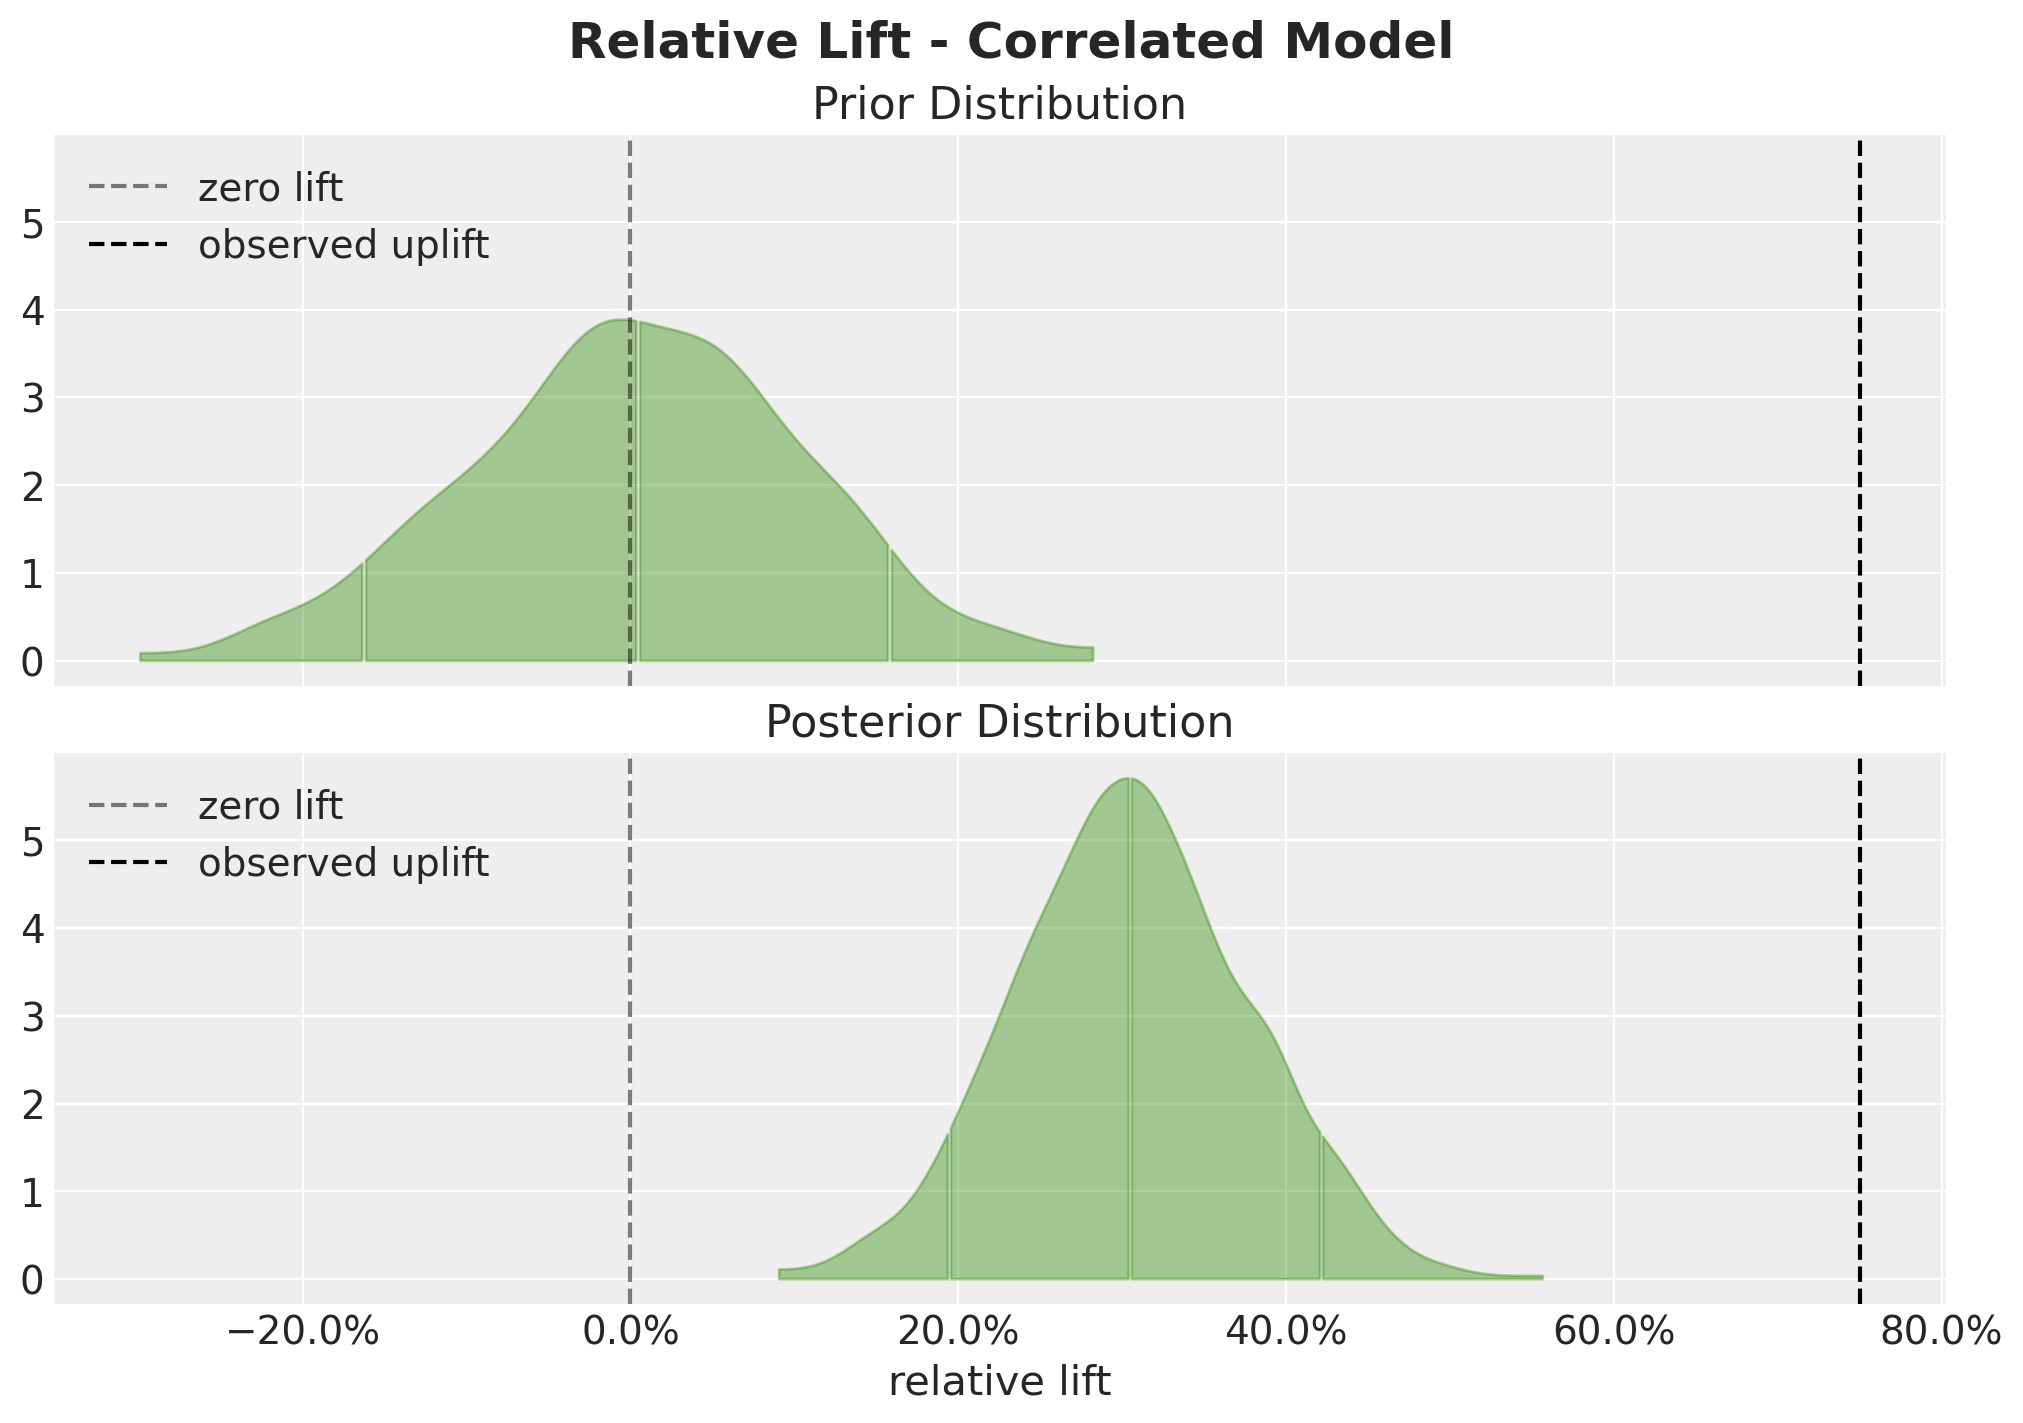

In [31]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(10, 7), sharex=True, sharey=True, layout="constrained"
)

az.plot_dist(
    correlated_prior_samples["prior"]["relative_lift"],
    color="C2",
    quantiles=[0.06, 0.5, 0.94],
    fill_kwargs={"alpha": 0.4},
    ax=ax[0],
)
ax[0].axvline(x=0, color="black", linestyle="--", alpha=0.5, label="zero lift")
ax[0].axvline(
    x=empirical_uplift,
    color="black",
    linestyle="--",
    label="observed uplift",
)
ax[0].legend(loc="upper left")
ax[0].set(title="Prior Distribution")

az.plot_dist(
    correlated_posterior_samples["posterior"]["relative_lift"],
    color="C2",
    quantiles=[0.06, 0.5, 0.94],
    fill_kwargs={"alpha": 0.4},
    ax=ax[1],
)
ax[1].axvline(x=0, color="black", linestyle="--", alpha=0.5, label="zero lift")
ax[1].axvline(
    x=empirical_uplift,
    color="black",
    linestyle="--",
    label="observed uplift",
)
ax[1].legend(loc="upper left")
ax[1].xaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=1))
ax[1].set(title="Posterior Distribution", xlabel="relative lift")

fig.suptitle("Relative Lift - Correlated Model", fontsize=18, fontweight="bold");

This plot shows the effect of conditioning on the observed data, the posterior distribution as shifted to the right and it has a smaller variance.